# Project setup

### Libraries import

In [1]:
import numpy as np

from PIL import Image
import rembg

import os
import io

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from scipy.spatial import distance

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import defaultdict

## Model selection

We use a pre-trained model, in particular VGG11 a deep convolutional network for largescale image classification. [[2]](#2)

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)

print(model)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\Usuario/.cache\torch\hub\v0.10.0.zip
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to C:\Users\Usuario/.cache\torch\hub\checkpoints\vgg11-8a719046.pth
100%|██████████| 507M/507M [05:38<00:00, 1.57MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## Leyers Selection

All selected layers are ReLU. To approximate the comparison of behavior between the intermediate and final layers, we selected layers 12, 14, 17, and 19.

In [3]:
selected_leyers = [12, 14, 17, 19]

for layer in selected_leyers:
  idx = int(layer)
  print(f"Architecture of the network in the specified layer number {idx}: {model.features[idx]}")

Architecture of the network in the specified layer number 12: ReLU(inplace=True)
Architecture of the network in the specified layer number 14: ReLU(inplace=True)
Architecture of the network in the specified layer number 17: ReLU(inplace=True)
Architecture of the network in the specified layer number 19: ReLU(inplace=True)


## Feature map extraction

In [4]:
class VGG11FeatureExtractor(nn.Module):
    def __init__(self, pretrained_model, selected_layer):
        super(VGG11FeatureExtractor, self).__init__()
        self.selected_layer = selected_layer # Saves the layer index to extract features from
        self.pretrained_model = pretrained_model # Stores the pretrained model for reference
        ## Constructs a sequential model that includes all layers of the pretrained model up to the specified selected_layer ##
        self.feature_extractor = nn.Sequential(*list(pretrained_model.features.children())[:selected_layer+1])

    def forward(self, input_img):
        ## The input image passes through the feature extractor, producing an output that contains the features extracted from the specified layer ##
        output = self.feature_extractor(input_img)
        return output

## Dataset Generation through image transformation

The dataset of images will be comformed by different transformation conditions.
These conditions are:
1. The image shifted x pixels to the right
2. The image shifted x pixels to the left
3. The image rotated x degrees to the right
4. The image rotated x degrees to the left
5. The image scaled by factor x, maintaining original image dimensions
6. The image scaled by factor y, maintaining original image dimensions
7. Seed image (original object without transformations and background)
8. Image with context (original image)

Following these transformations, each image—including the seed and context images—will be converted to tensors for model input.

A control image, different from the original image, will only be converted to a tensor without any transformations.

The seed image will serve as a baseline for computing metrics such as Global Average Pooling (GAP) and channel-wise average distance, aiding in the analysis of neural layer activation patterns, selectivity, and invariance.


### Transformation

In [5]:
def scale_object(obj, scale_factor):
    """
    Scales an image object by a specified scale factor while preserving the original dimensions.

    This function resizes the input image according to the given scale factor and centers the
    scaled image on a transparent background. The final output is a composite image over a
    white background, converted to RGB format.

    Parameters:
    obj (PIL.Image.Image): The image object to be scaled, must be a PIL Image instance.
    scale_factor (float): The factor by which to scale the image. A value greater than 1
                          increases the size, while a value less than 1 decreases it.

    Returns:
    PIL.Image.Image: A new image object scaled and centered on a white background,
                     converted to RGB format.
    """
    width, height = obj.size
    scaled_width = int(width * scale_factor)
    scaled_height = int(height * scale_factor)

    # Resize the object
    scaled_obj = obj.resize((scaled_width, scaled_height), Image.Resampling.LANCZOS)

    # Background image with the same size as the original image
    bg_img = Image.new("RGBA", (width, height), (0, 0, 0, 0))

    # Position calculation to center scaled_obj
    offset_x = (width - scaled_width) // 2
    offset_y = (height - scaled_height) // 2

    bg_img.paste(scaled_obj, (offset_x, offset_y), scaled_obj)

    # Compose over a white background
    white_bg = Image.new("RGBA", (width, height), (255, 255, 255, 255))
    result = Image.alpha_composite(white_bg, bg_img)

    # Remove alpha channel
    return result.convert("RGB")

In [6]:
def shift_object(obj, shift_pixels):
    """
    Shifts an image object horizontally by a specified number of pixels, creating two
    versions: one shifted to the right and the other shifted to the left.

    This function takes the input image and moves it horizontally based on the provided
    pixel value. It ensures that the image does not go out of bounds by adjusting the
    offsets accordingly. The final output consists of two images, each centered on a
    white background.

    Parameters:
    obj (PIL.Image.Image): The image object to be shifted, must be a PIL Image instance.
    shift_pixels (int): The number of pixels to shift the image. Positive values shift
                        the image to the right, while negative values shift it to the left.

    Returns:
    tuple: A tuple containing two PIL.Image.Image objects:
        - final_right (PIL.Image.Image): The image shifted to the right, centered on a
                                           white background and converted to RGB format.
        - final_left (PIL.Image.Image): The image shifted to the left, centered on a
                                          white background and converted to RGB format.
    """
    width, height = obj.size

    # Create a transparent background of the same size
    shifted_right = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    shifted_left = Image.new("RGBA", (width, height), (0, 0, 0, 0))

    # Define how many pixels to move (making sure not to go out of bounds)
    right_offset = min(shift_pixels, width)
    left_offset = max(-width, shift_pixels * -2)

    # Paste the image onto the transparent background
    shifted_right.paste(obj, (right_offset, 0), obj)
    shifted_left.paste(obj, (left_offset, 0), obj)

    # Create a white background
    white_background_right = Image.new("RGBA", (width, height), (255, 255, 255, 255))
    white_background_left = Image.new("RGBA", (width, height), (255, 255, 255, 255))

    # Composite the final images onto a white background
    final_right = Image.alpha_composite(white_background_right, shifted_right)
    final_left = Image.alpha_composite(white_background_left, shifted_left)

    # Convert to RGB to remove the alpha channel before returning
    return final_right.convert("RGB"), final_left.convert("RGB")

In [7]:
def image_transform(image_path, shift_pixels, rotation_angle, scale_factor1, scale_factor2, output_dir="../images/transformedImages"):
    """
    Applies various transformations to an image and saves the results.

    This function takes an input image and performs a series of transformations on the object
    within it, including shifting, rotating, and scaling. The transformations result in
    multiple output images, each saved in the specified output directory. The original object
    is also saved without any transformations.

    Transformation Conditions:
    1. Object shifted x pixels to the right.
    2. Object shifted x pixels to the left.
    3. Object rotated x degrees to the right.
    4. Object rotated x degrees to the left.
    5. Object scaled by the first specified factor, maintaining original image dimensions.
    6. Object scaled by the second specified factor, maintaining original image dimensions.
    7. Seed object (original object without transformations and without background).
    8. Object with context (the original image).

    Parameters:
    image_path (str): The file path to the original image to be transformed.
    shift_pixels (int): The number of pixels to shift the object horizontally (positive for right, negative for left).
    rotation_angle (float): The angle in degrees to rotate the object (positive for clockwise, negative for counterclockwise).
    scale_factor1 (float): The first scale factor to resize the object while maintaining original dimensions.
    scale_factor2 (float): The second scale factor to resize the object while maintaining original dimensions.
    output_dir (str, optional): The directory where the transformed images will be saved. Defaults to "/content/".

    Returns:
    None: The function saves the transformed images directly to the specified output directory and does not return any values.
    """

    # Load the image
    image = Image.open(image_path)
    print(f'Original Image Properties: \nWidth: {image.width} Height: {image.height} \nMode: {image.mode} Format: {image.format} \nType: {type(image)}')

    # Remove background to isolate the object
    image_array = np.array(image)
    object_array = rembg.remove(image_array)
    obj = Image.fromarray(object_array)
    print(f'\nObject Properties: \nWidth: {obj.width} Height: {obj.height} \nMode: {obj.mode} \nType: {type(obj)}')

    # Shift the object to the right and left
    obj_shifted_right, obj_shifted_left = shift_object(obj, shift_pixels)

    # Rotate the object
    obj_rotated_right = Image.new(obj.mode, obj.size, (255, 255, 255))
    obj_rotated_right.paste(obj.rotate(-rotation_angle, expand=False), (0, 0))

    obj_rotated_left = Image.new(obj.mode, obj.size, (255, 255, 255))
    obj_rotated_left.paste(obj.rotate(rotation_angle, expand=False), (0, 0))

    # Scale the object by two different factors
    obj_scaled1 = scale_object(obj, scale_factor1)
    obj_scaled2 = scale_object(obj, scale_factor2)

    # Save all transformed images to output directory
    obj_shifted_right.save(os.path.join(output_dir, 'object_shifted_right.png'))
    obj_shifted_left.save(os.path.join(output_dir, 'object_shifted_left.png'))
    obj_rotated_right.save(os.path.join(output_dir, 'object_rotated_right.png'))
    obj_rotated_left.save(os.path.join(output_dir, 'object_rotated_left.png'))
    obj_scaled1.save(os.path.join(output_dir, 'object_scaled1.png'))
    obj_scaled2.save(os.path.join(output_dir, 'object_scaled2.png'))
    obj.save(os.path.join(output_dir, 'seed_object.png'))
    image.save(os.path.join(output_dir, 'object_with_context.png'))

In [25]:
# Method to show images generated after the transformation
def show_image(img, image_path= "../images/transformedImages"):
    """
    Show images generated after the transformation
    """
    image = os.path.join(image_path, img)
    img_data = mpimg.imread(image)  # Read the image
    plt.imshow(img_data) # Display the image
    plt.axis('off') # Turn off axes
    plt.title(img)  # Display the image title
    plt.show() # Show the image

### Transformation to a tensor

In [9]:
# Transformation of image into tensor
def load_and_transform_image(image_path):
    """
    Loads an image from the specified path and applies a series of transformations.

    This function opens an image file:
    1. converts it to RGB format,
    2. resizes it to 224x224 pixels,
    3. converts it to a tensor,
    4. and normalizes it using predefined mean and standard deviation values.

    Parameters:
    image_path (str): The file path to the image to be loaded and transformed.

    Returns:
    torch.Tensor: A tensor representing the transformed image with an added batch dimension.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

## Data Collection methods

### Activations

In [10]:
def get_activations(model, image, layers):
    """
    Retrieves the activations of an image through the model.

    Parameters:
    - model: The neural network model used to obtain the activations.
    - image: A tensor representing the input image.
    - layers: A list of indices indicating the layers whose activations are to be visualized.

    Returns:
    - activations: A list containing the activations of the specified layers.
    """
    activations = []
    x = image

    for i, layer in enumerate(model):
        x = layer(x)
        if i in layers:
            activations.append(x)

    return activations


### Invariance calculation

For the invariance calculation of neural layer activations, we will use the Global Average Pooling (GAP) and Average Activations by Channel as metrics. GAP serves as a global metric for summarizing layer activations, while the channel-wise average distance provides insights into the extent of feature shift across channels.

#### Average Activations by Channel

##### What is the Average Activations by Channel?
It is a technique used in convolutional neural networks to reduce the dimensionality of activations from a convolutional layer by averaging the activations across the channel axis.

##### How Does It Work?
Suppose you have an activation coming from a convolutional layer with the shape [batch_size, channels, height, width], where:

* **batch_size** is the number of images in a batch.
* **channels** corresponds to the number of feature maps generated by the convolutional layer.
* **height** and **width** are the spatial dimensions of these feature maps.

The average activations by channel take the average values along the channel axis (dimension 1). As a result, it reduces the dimensionality of the activations to a shape of [batch_size, height, width], where each value in the new matrix is the average of the values across all channels at that specific spatial location.

##### What Is It Used For?
This method is primarily used for:
1. **Reducing Dimensionality:** It decreases the amount of data without losing key spatial information, which can help reduce computational complexity.
2. **Summarizing Channel Information:** It provides a global view of how all channels respond at each spatial location in the image.

##### Benefits
Channel-wise mean pooling is useful in cases where a compact representation of the activations is needed without discarding spatial information while integrating data from all channels at each image location.


In [11]:
def average_channel_activations(activations):
    """
    Function that calculates the average activations by Channel per layer.
    Receives the activations calculated with get_activations.
    """
    average_activations = []
    for activation in activations:
        avg_activation = torch.mean(activation, dim=1).squeeze().detach().cpu().numpy()
        average_activations.append(avg_activation)
    return average_activations


##### Distance calculation

We can use the average channel activations of the seed image and its transformed version to gain insights into how the transformation has affected the image's representation in the feature space. To achieve this, we calculate the Euclidean distance between the two vectors (the average activations of the seed and transformed images) and normalize this distance by the distance between the seed image and the control image. This ratio allows us to understand the relative impact of the transformation compared to the baseline established by the control image.

In [12]:
def calculate_average_channel_distance(seed_avg_channel, transformed_avg_channel, control_avg_channel, layer):
    """
    Calculate the ratio of the distance between the seed and transformed images
    to the distance between the seed and control image.

    Parameters:
    - seed_avg_channel: Average channel activation for the seed image (2D array).
    - transformed_avg_channel: Average channel activation for the transformed image (2D array).
    - control_avg_channel: Average channel activation for the control image (2D array).
    - layer: The name of the layer being analyzed (string).

    Returns:
    - final_channel_distance: The ratio of the distance between the seed and transformed images
      to the distance between the seed and control images (float).
    """

    # Calculate Euclidean distances
    distance_images = distance.euclidean(seed_avg_channel.flatten(), transformed_avg_channel.flatten())
    distance_classes = distance.euclidean(seed_avg_channel.flatten(), control_avg_channel.flatten())

    # Avoid division by zero
    if distance_classes == 0:
        print(f"Warning: Control distance is zero for layer {layer}. Returning infinity.")
        return float('inf')

    final_channel_distance = distance_images / distance_classes

    # Print results
    print(f"\nThe Euclidean distance between the vectors of an image and its transformation using the average channel activation of layer {layer} is: {distance_images:.3f}")
    print(f"\nThe Euclidean distance between classes of the vectors of two distinct images using the average channel activation of layer {layer} is: {distance_classes:.3f}")
    print(f"\nThe final distance between the vectors using the average channel activation for layer {layer} is: {final_channel_distance:.3f}\n")

    return final_channel_distance

#### Global Average Pooling calculation

##### What is Global Average Pooling?

Global Average Pooling (GAP) is a technique used in convolutional neural networks to reduce an activation matrix (or activation tensor) to a single average value per channel, consolidating all spatial information into a single representative value for each channel. This method is especially useful in the final stages of neural networks, just before the classification layers, as it helps reduce data dimensionality without losing relevant information.

##### How Does It Work?

Consider an activation that comes from a convolutional layer with the shape \[batch\_size, channels, height, width\], where:

- **batch\_size** is the number of images in a batch,
- **channels** is the number of feature maps generated by the convolutional layer,
- **height** and **width** are the spatial dimensions of these feature maps.

GAP averages the values along the spatial dimensions (height and width) and often along the batch dimension, resulting in a tensor with the shape \[channels\]. In other words, for each channel, all values within that channel are averaged to produce a single value.

##### What Is It Used For?

- **Dimensionality Reduction:** GAP converts spatial activations into a single value per channel, which significantly reduces the data size and facilitates the use of activations in dense or classification layers.
- **Overfitting Prevention:** By reducing activations to a single value per channel, GAP prevents the model from overly relying on specific object positions in an image, which can help prevent overfitting.
- **Interpretability:** GAP simplifies model interpretation by reducing each channel to a single value, which reflects the average activation across the entire image.

##### Benefit

Global Average Pooling is particularly effective in the final stages of a convolutional network, just before the classification layer. It reduces the dimensionality of activations and enables the network to focus on the general presence of features in the image rather than their exact positions, making the model more robust and less susceptible to overfitting.

In the image below, can be observed the transformation for three channels with height=6 (h) and width=6 (w).

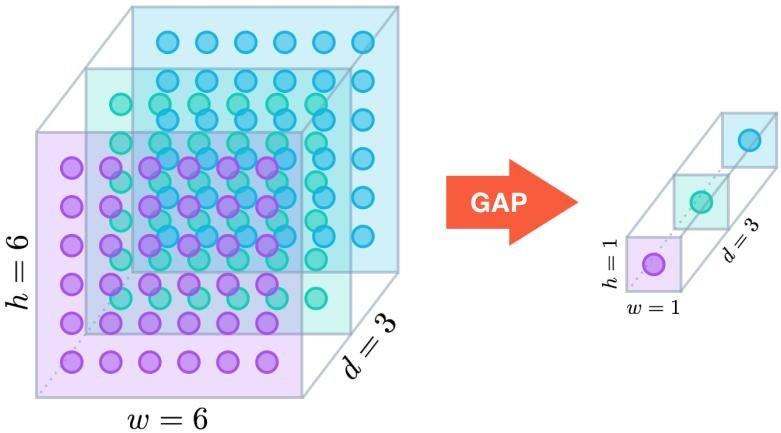

In [13]:
def gap_activations(activations):
    """
    Function that calculates the average activations per layer.
    Receives the activations calculated with get_activations.
    """
    gap_activations = []
    for activation in activations:
        avg_activation = torch.mean(activation, dim=(0, 2, 3)).detach().cpu().numpy()
        gap_activations.append(avg_activation)
    return gap_activations

##### Distance calculation

We can use the GAP activations of the seed image and its transformed version to gain insights into how the transformation has affected the image's representation in the feature space. To achieve this, we calculate the Euclidean distance between the two vectors (the average activations of the seed and transformed images) and normalize this distance by the distance between the seed image and the control image. This ratio allows us to understand the relative impact of the transformation compared to the baseline established by the control image.

In [14]:
def calculate_gap_distance(seed_avg_gap, transformed_avg_gap, control_avg_channel, layer):
    """
    Calculate the ratio of the distance between the seed and transformed images
    to the distance between the seed and control image.

    Parameters:
    - seed_avg_gap: Average GAP activation for the seed image (2D array).
    - transformed_avg_gap: Average GAP activation for the transformed image (2D array).
    - control_avg_channel: Average GAP activation for the control image (2D array).
    - layer: The name of the layer being analyzed (string).

    Returns:
    - gap_distance_result: The ratio of the distance between the seed and transformed images
      to the distance between the seed and control images (float).
    """

    # Calculate Euclidean distances
    distance_transform = distance.euclidean(seed_avg_gap.flatten(), transformed_avg_gap.flatten())
    distance_control = distance.euclidean(seed_avg_gap.flatten(), control_avg_channel.flatten())

    # Avoid division by zero
    if distance_control == 0:
        print(f"Warning: Control distance is zero for layer {layer}. Returning infinity.")
        return float('inf')

    gap_distance_result = distance_transform / distance_control

    # Print results
    print(f"\nThe Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer {layer} is: {distance_transform:.3f}")
    print(f"\nThe Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer {layer} is: {distance_control:.3f}")
    print(f"\nThe final distance between the vectors using average GAP activations for layer {layer} is: {gap_distance_result:.3f}\n")

    return gap_distance_result

### Sparseness Calculation

To quantify sparseness we used a nonparametric statistic defined by the formula:

$S = \frac{1-\frac{(\frac{1}{n}\sum_{1}^{n}r_i)^{2}}{\frac{1}{n}\sum_{1}^{n}r_i^{2}}}{1-\frac{1}{n}}$ [[3]](#3)

where:

$r_i$ : Response (or activation) of a neuron (or feature map) to each stimulus.

$n$ : Number of responses (transformations or stimuli) used to evaluate sparseness.

The formula measures how active a neuron (or feature map) is across a range of stimuli. A sparseness value closer to 1 indicates that the neuron responds selectively (sparsely) to only a few stimuli.

To provide some intuition, the measure asses the ratio of the squared grand mean firing rate to the average of the means squared, and S inverts the metric such that neurons that respond to a smaller fraction of images produce higher sparseness measures.

For instance, if a neuron responds to all images with approximately equal firing rates, the numerator and denominator will be nearly equal, resulting in 1 (and S of 0). For a neuron that responds to only one image, the average of the means squared (the denominator) will exceed the low average mean rate (the numerator), resulting in a of 0 (and S of 1). [[4]](#4)




In [15]:
def sparseness_calculation(activations):
    """
    Calculates sparseness for activations.
    Sparseness formula: S = (1 - (mean_response^2 / mean_squared_response)) / (1 - 1/n)
    """

    n = activations.shape[1]  # number of transformations/stimuli

    # Calculate average response and squared response per feature map
    mean_response = np.mean(activations, axis=1)
    mean_squared_response = np.mean(activations**2, axis=1)

    # Calculate sparseness per feature map
    # Avoid division by zero
    sparseness_values = np.where(mean_squared_response != 0,
                                  (1 - (mean_response**2 / mean_squared_response)) / (1 - 1/n),
                                  0)

    return sparseness_values

In [16]:
def compute_sparseness_for_activations(layer_name, activations):
    """
    Reshapes activations and calculates sparseness, returning the results.
    """
    activation_reshaped = activations.view(activations.size(0), -1).cpu().detach().numpy()
    sparseness = sparseness_calculation(activation_reshaped)
    return layer_name, sparseness

## Analysis through Visualization

We visualize through plots the activations of the model at various layers to gain insights into its behavior and performance. Two key aspects of this visualization include:

1. **Feature Maps and Average Activations:** Using the plot_feature_maps_and_avg_activations function, we analyze the average activations across different layers for various input images. This helps us understand how the model responds to different transformations and how well it captures relevant features from the input data.

2. **Sparseness Analysis:** The plot_sparseness function complements this analysis by providing histograms of the activations from each layer. This allows us to assess the sparseness of the activations, indicating how many neurons are firing in response to the inputs. A higher degree of sparsity can suggest that the model is effectively filtering out noise and focusing on the most salient features.

Together, these visualizations enable us to explore both the richness of the learned representations and the efficiency of the network’s activations across layers. The following plots illustrate these insights:

In [17]:
def plot_sparseness(activations, layers):
    """
    Function to get a first insight about sparseness, using the histograms of activations.
    """
    fig, axes = plt.subplots(1, len(activations), figsize=(15, 5))
    for i, activation in enumerate(activations):
        # Flatten all activations of the current layer
        activations_flat = activation.flatten().detach().cpu().numpy()
        axes[i].hist(activations_flat, bins=50, color='blue', alpha=0.7)
        axes[i].set_title(f'Layer {layers[i]}')
        axes[i].set_yscale('log')  # Use logarithmic scale for better visualization
    plt.tight_layout()
    plt.show()


In [18]:
def plot_avg_act_channel(axes, x, layer_idx, seed_map, transform_map, control_map):
    """Plot Average activations by chanel for a given layer."""

    axes[x, 0].imshow(seed_map, cmap='viridis', aspect='auto')
    axes[x, 0].set_title(f'Layer {layer_idx}\nAverage Activations by Channel \nSeed Image')

    axes[x, 1].imshow(transform_map, cmap='viridis', aspect='auto')
    axes[x, 1].set_title(f'Layer {layer_idx} \nAverage Activations by Channel \nTransformed Image')

    axes[x, 2].imshow(control_map, cmap='viridis', aspect='auto')
    axes[x, 2].set_title(f'Layer {layer_idx}\nAverage Activations by Channel \nControl Image')

In [19]:
def plot_hist_avg_act_channel(axes, x, layer_idx, seed_map, transform_map, control_map):
    """Plot Histogram of Average activations by chanel for a given layer."""

    xmin = min(seed_map.min(), transform_map.min(), control_map.min())
    xmax = max(seed_map.max(), transform_map.max(), control_map.max())

    axes[x, 0].hist(seed_map, bins=50, color='blue', alpha=0.7)
    axes[x, 0].set_yscale('log')
    axes[x, 0].set_xlim([xmin, xmax])
    axes[x, 0].set_title(f'Layer {layer_idx} \nActivations Histogram \nAverage by Channel \nSeed Image')

    axes[x, 1].hist(transform_map, bins=50, color='blue', alpha=0.7)
    axes[x, 0].set_yscale('log')
    axes[x, 0].set_xlim([xmin, xmax])
    axes[x, 1].set_title(f'Layer {layer_idx} \nActivations Histogram \nAverage by Channel \nTransformed Image')

    axes[x, 2].hist(control_map, bins=50, color='blue', alpha=0.7)
    axes[x, 0].set_yscale('log')
    axes[x, 0].set_xlim([xmin, xmax])
    axes[x, 2].set_title(f'Layer {layer_idx} \nActivations Histogram \nAverage by Channel \nControl Image')

In [20]:
def plot_gap_activations(axes, x, layer_idx, seed_gap, transform_gap, control_gap):
    """Plot GAP activations for a given layer."""

    ymin = min(seed_gap.min(), transform_gap.min(), control_gap.min())
    ymax = max(seed_gap.max(), transform_gap.max(), control_gap.max())

    axes[x, 0].plot(seed_gap)
    axes[x, 0].set_ylim([ymin, ymax])
    axes[x, 0].set_title(f'Layer {layer_idx} \nGAP Average Activations \nSeed Image')

    axes[x, 1].plot(transform_gap)
    axes[x, 1].set_ylim([ymin, ymax])
    axes[x, 1].set_title(f'Layer {layer_idx} \nGAP Average Activations \nTransformed Image')

    axes[x, 2].plot(control_gap)
    axes[x, 2].set_ylim([ymin, ymax])
    axes[x, 2].set_title(f'Layer {layer_idx} \nAverage Activations by Channel \nControl Image')

In [21]:
def plot_feature_maps_and_avg_activations(
        seed_avg_channel_act,
        transform_avg_channel_act,
        crtl_avg_channel_act,
        seed_avg_gap_act,
        transform_avg_gap_act,
        crtl_avg_activation_gap,
        layers):
    """
    Visualize average activations by chanel and GAP activations.

    Parameters:
    - seed_avg_channel_act: Average activations by chanel for the seed image.
    - transform_avg_channel_act: Average activations by chanelfor the transformed image.
    - crtl_avg_channel_act: Average activations by chanel for the control image.
    - seed_avg_gap_act: Global average poolings activations for the seed image.
    - transform_avg_gap_act: Global average poolings activations for the transformed image.
    - crtl_avg_activation_gap: Global average poolings activations for the control image.
    - layers: List of layers to visualize.

    Returns:
    - gap_distances_per_layer: Distances calculated for each layer based on GAP activations.
    - avg_channel_distances_per_layer: Distances calculated for each layer based on average channel activations.
    """
    num_layers = len(layers)
    fig, axes = plt.subplots(num_layers * 3, 3, figsize=(10, 8 * num_layers))

    gap_distances_per_layer = []
    avg_channel_distances_per_layer = []

    for i in range(num_layers):
        #########################################
        # Row 1: Average Activations by Channel
        #########################################

        plot_avg_act_channel(
            axes,
            i * 3,
            i,
            seed_avg_channel_act[i],
            transform_avg_channel_act[i],
            crtl_avg_channel_act[i])

        ########################################################
        # Row 2: Histogram with Average Activations by Channel
        ########################################################

        plot_hist_avg_act_channel(
            axes,
            i * 3 + 1,
            i,
            seed_avg_channel_act[i].flatten(),
            transform_avg_channel_act[i].flatten(),
            crtl_avg_channel_act[i].flatten())

        ################################
        # Row 3: Global Average Pooling
        ################################

        plot_gap_activations(
            axes,
            i * 3 + 2,
            i,
            seed_avg_gap_act[i],
            transform_avg_gap_act[i],
            crtl_avg_activation_gap[i])

        ############################################################################
        # Calculate the distance between the two activation vectors for each layer #
        ############################################################################
        # GAP Distance Calculation #
        gap_distance = calculate_gap_distance(
            seed_avg_gap_act[i],
            transform_avg_gap_act[i],
            crtl_avg_activation_gap[i],
            layers[i])
        gap_distances_per_layer.append(gap_distance)

        # Average Channel Distance Calculation #
        avg_channel_distance = calculate_average_channel_distance(
            seed_avg_channel_act[i],
            transform_avg_channel_act[i],
            crtl_avg_channel_act[i],
            layers[i])
        avg_channel_distances_per_layer.append(avg_channel_distance)

    plt.tight_layout(pad=4.0)
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(layers, gap_distances_per_layer, marker='o', linestyle='-', color='b', label='GAP Distance')
    plt.plot(layers, avg_channel_distances_per_layer, marker='s', linestyle='--', color='r', label='Average Channel Distance')
    plt.xlabel('Layer')
    plt.ylabel('Final Distance')
    plt.title('Final Distance between Activation Vectors')
    plt.legend()
    plt.grid(True)
    plt.show()

    return gap_distances_per_layer, avg_channel_distances_per_layer

# Project Execution

## Set images

In [22]:
# Seed image
seed_image_path = '../images/squirrel.png'

In [23]:
# Control image
control_image_path = '../images/termo.png'

## Dataset Generation

In [24]:
# Seed image transformation
image_transform(seed_image_path, shift_pixels=250, rotation_angle=30, scale_factor1=0.5, scale_factor2=1.5)

Original Image Properties: 
Width: 2048 Height: 1536 
Mode: RGB Format: PNG 
Type: <class 'PIL.PngImagePlugin.PngImageFile'>


100%|#######################################| 176M/176M [00:00<00:00, 40.6GB/s]



Object Properties: 
Width: 2048 Height: 1536 
Mode: RGBA 
Type: <class 'PIL.Image.Image'>


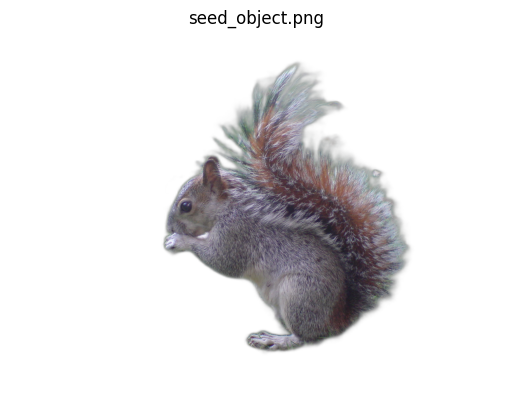

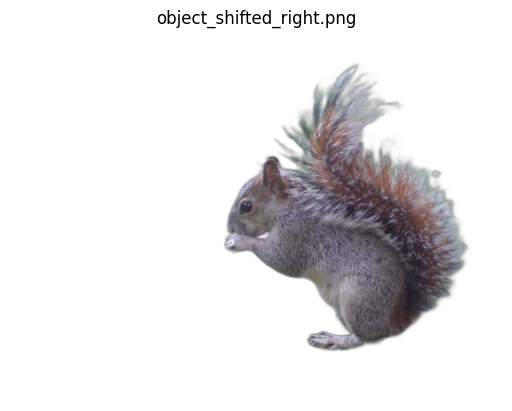

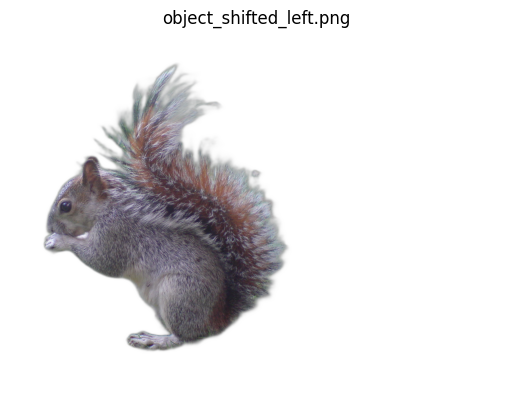

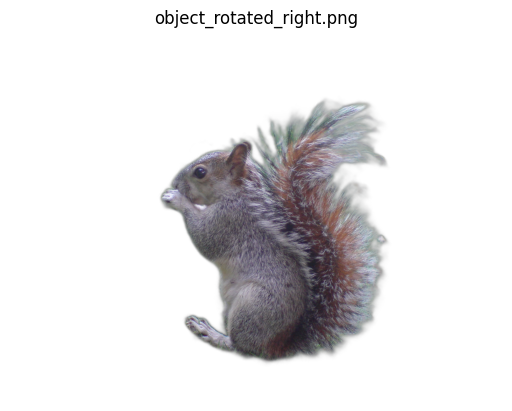

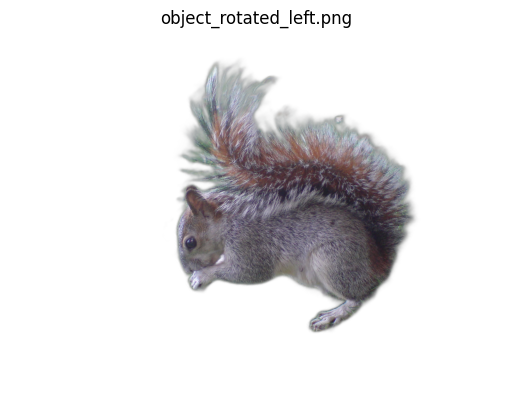

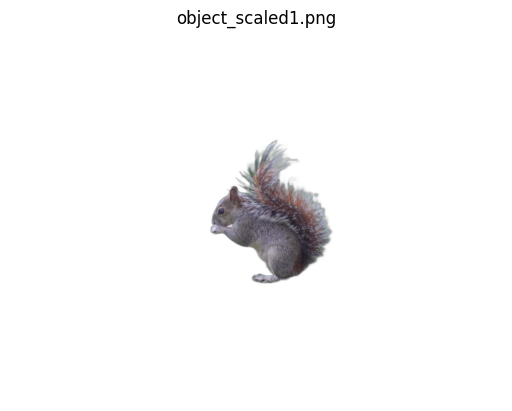

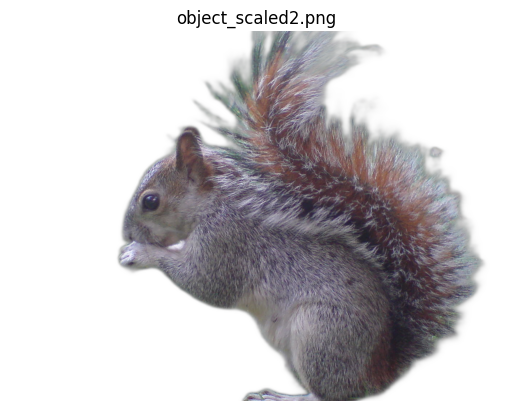

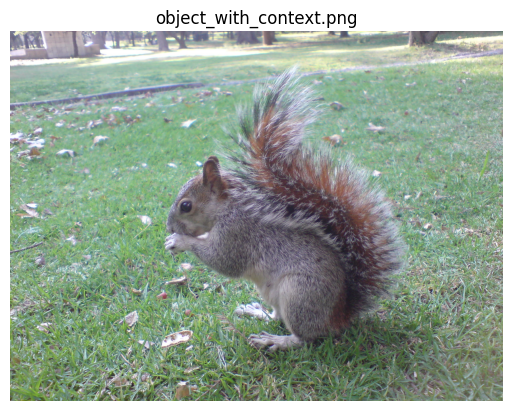

In [30]:
# List of transformed images
seed_image = "seed_object.png"
transform_image_list = [
    "object_shifted_right.png", "object_shifted_left.png",
    "object_rotated_right.png", "object_rotated_left.png",
    "object_scaled1.png", "object_scaled2.png",
    "object_with_context.png"
]

show_image(seed_image)

for img in transform_image_list:
    show_image(img)

## Images to tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


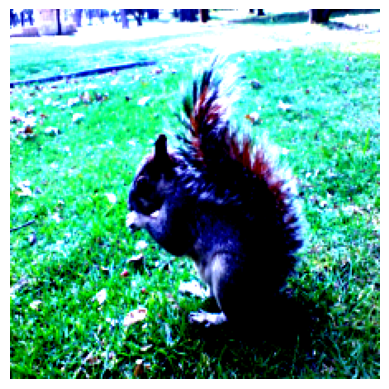

In [27]:
# Seed image
seed_tensor = load_and_transform_image(seed_image_path )

plt.imshow(seed_tensor.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


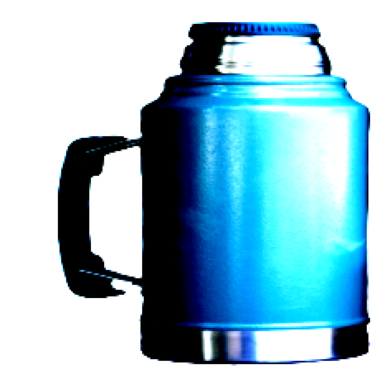

In [28]:
# Image for control
control_tensor = load_and_transform_image(control_image_path)

plt.imshow(control_tensor.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

In [31]:
# Store the transformed image tensors
transform_images_tensor = []
transform_img_path = "../images/transformedImages"

for image_file in transform_image_list:

    image_path = os.path.join(transform_img_path, image_file)

    # Apply the custom transformation function
    transform_img_tensor = load_and_transform_image(image_path)

    # Append the resulting tensor to the list
    transform_images_tensor.append(transform_img_tensor)

## Invariance analysis

In this section, we analyze the invariance of the model layer by layer, transformation by transformation. This analysis aims to provide insights into how the model's feature representations change—or remain consistent—across different transformations of the input images. The findings from this analysis will be further evaluated in the context of the overall project.

In [32]:
# These lists are initialized to store distances for each layer from the different processed images.
gap_distances_per_layer, avg_channel_distances_per_layer = [], []
gap_distances_all_list = []
avg_channels_distances_all_list = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_shifted_right.png


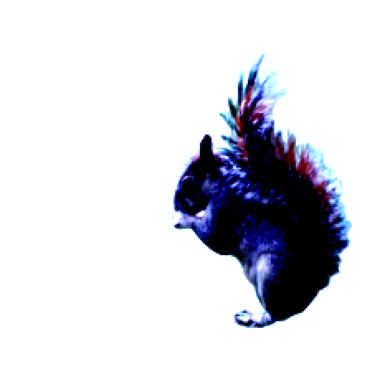


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 12 is: 14.360

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 12 is: 15.629

The final distance between the vectors using average GAP activations for layer 12 is: 0.919


The Euclidean distance between the vectors of an image and its transformation using the average channel activation of layer 12 is: 8.470

The Euclidean distance between classes of the vectors of two distinct images using the average channel activation of layer 12 is: 8.275

The final distance between the vectors using the average channel activation for layer 12 is: 1.024


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 14 is: 7.895

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 14 is: 

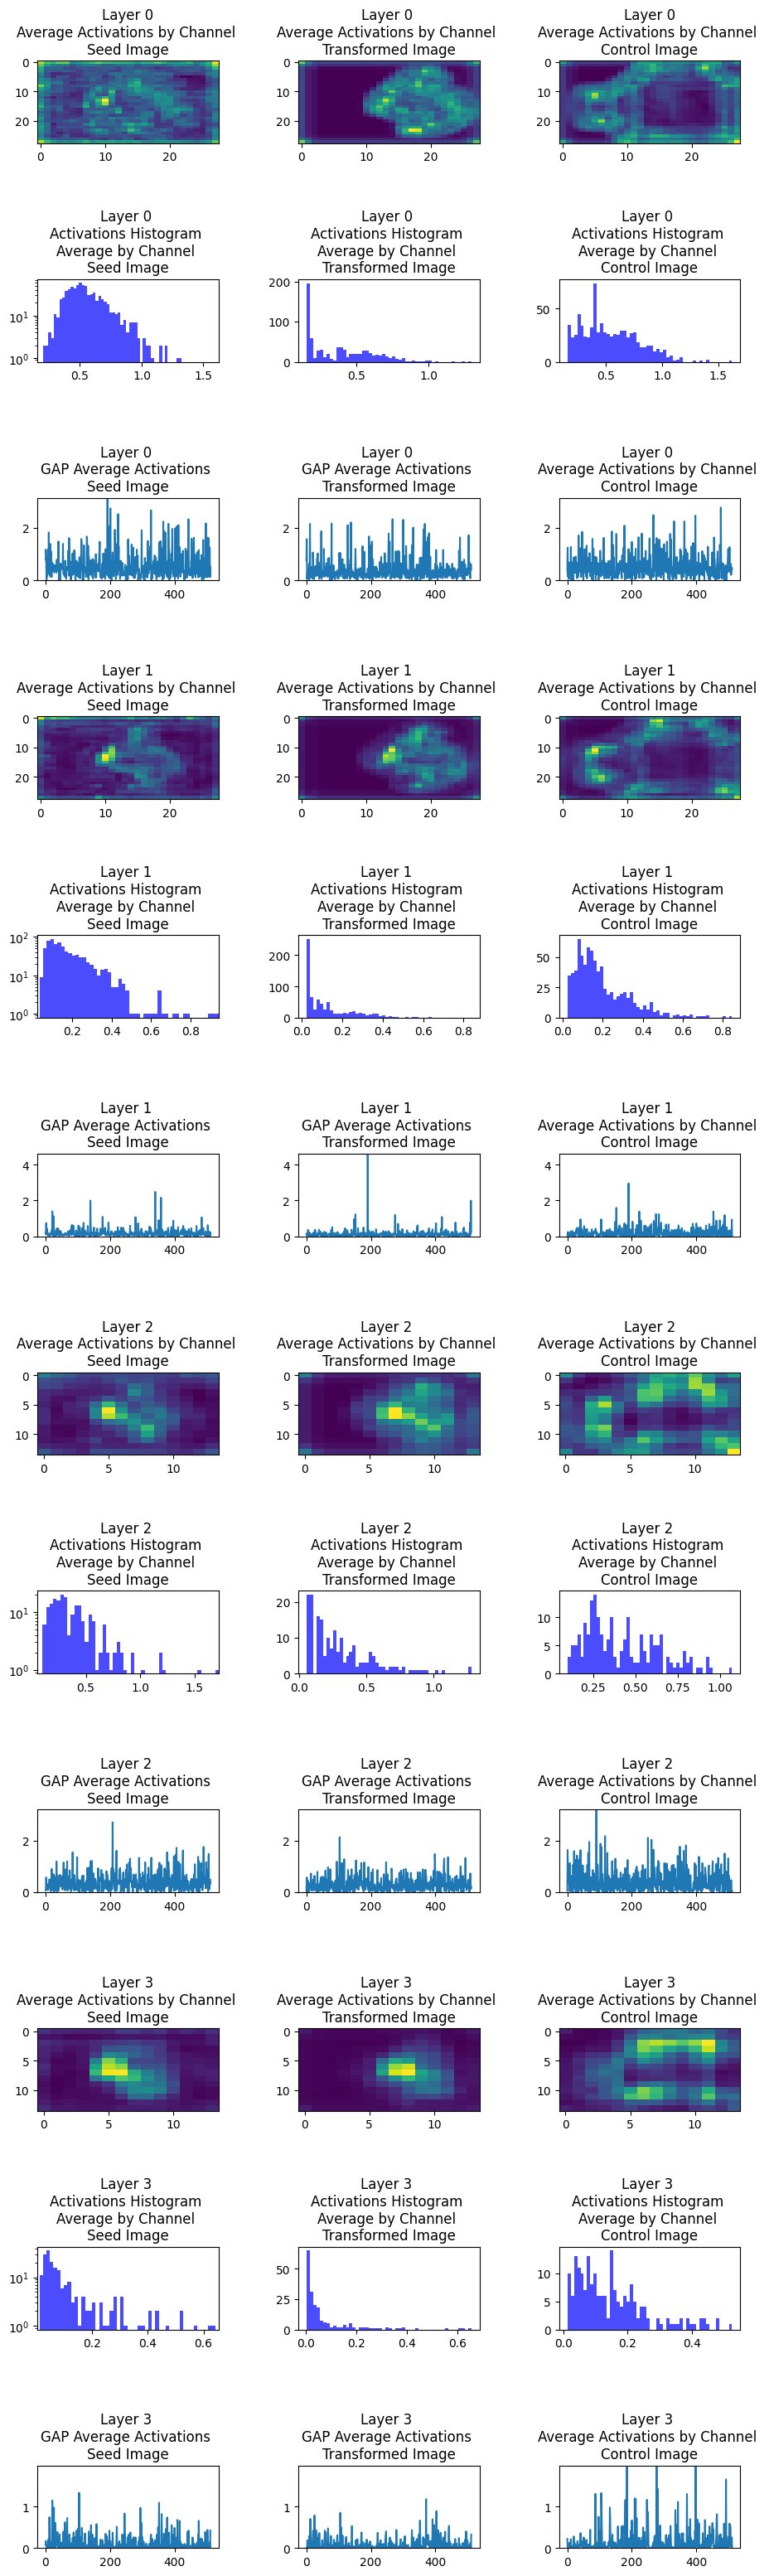

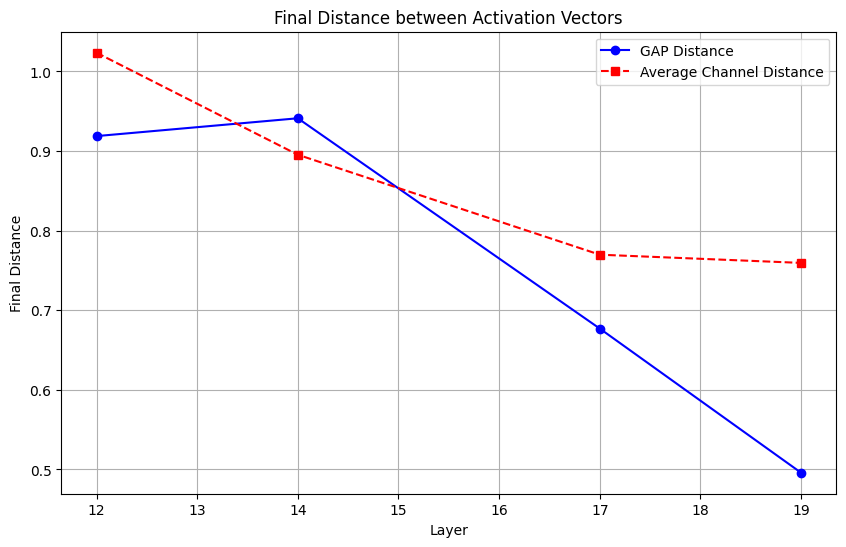

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_shifted_left.png


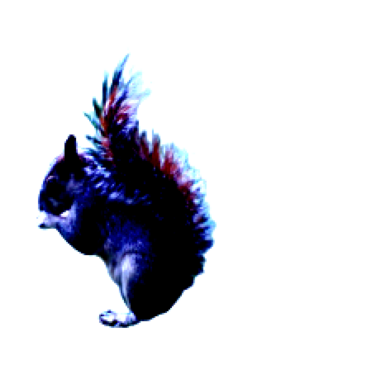


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 12 is: 14.353

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 12 is: 15.629

The final distance between the vectors using average GAP activations for layer 12 is: 0.918


The Euclidean distance between the vectors of an image and its transformation using the average channel activation of layer 12 is: 8.640

The Euclidean distance between classes of the vectors of two distinct images using the average channel activation of layer 12 is: 8.275

The final distance between the vectors using the average channel activation for layer 12 is: 1.044


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 14 is: 7.902

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 14 is: 

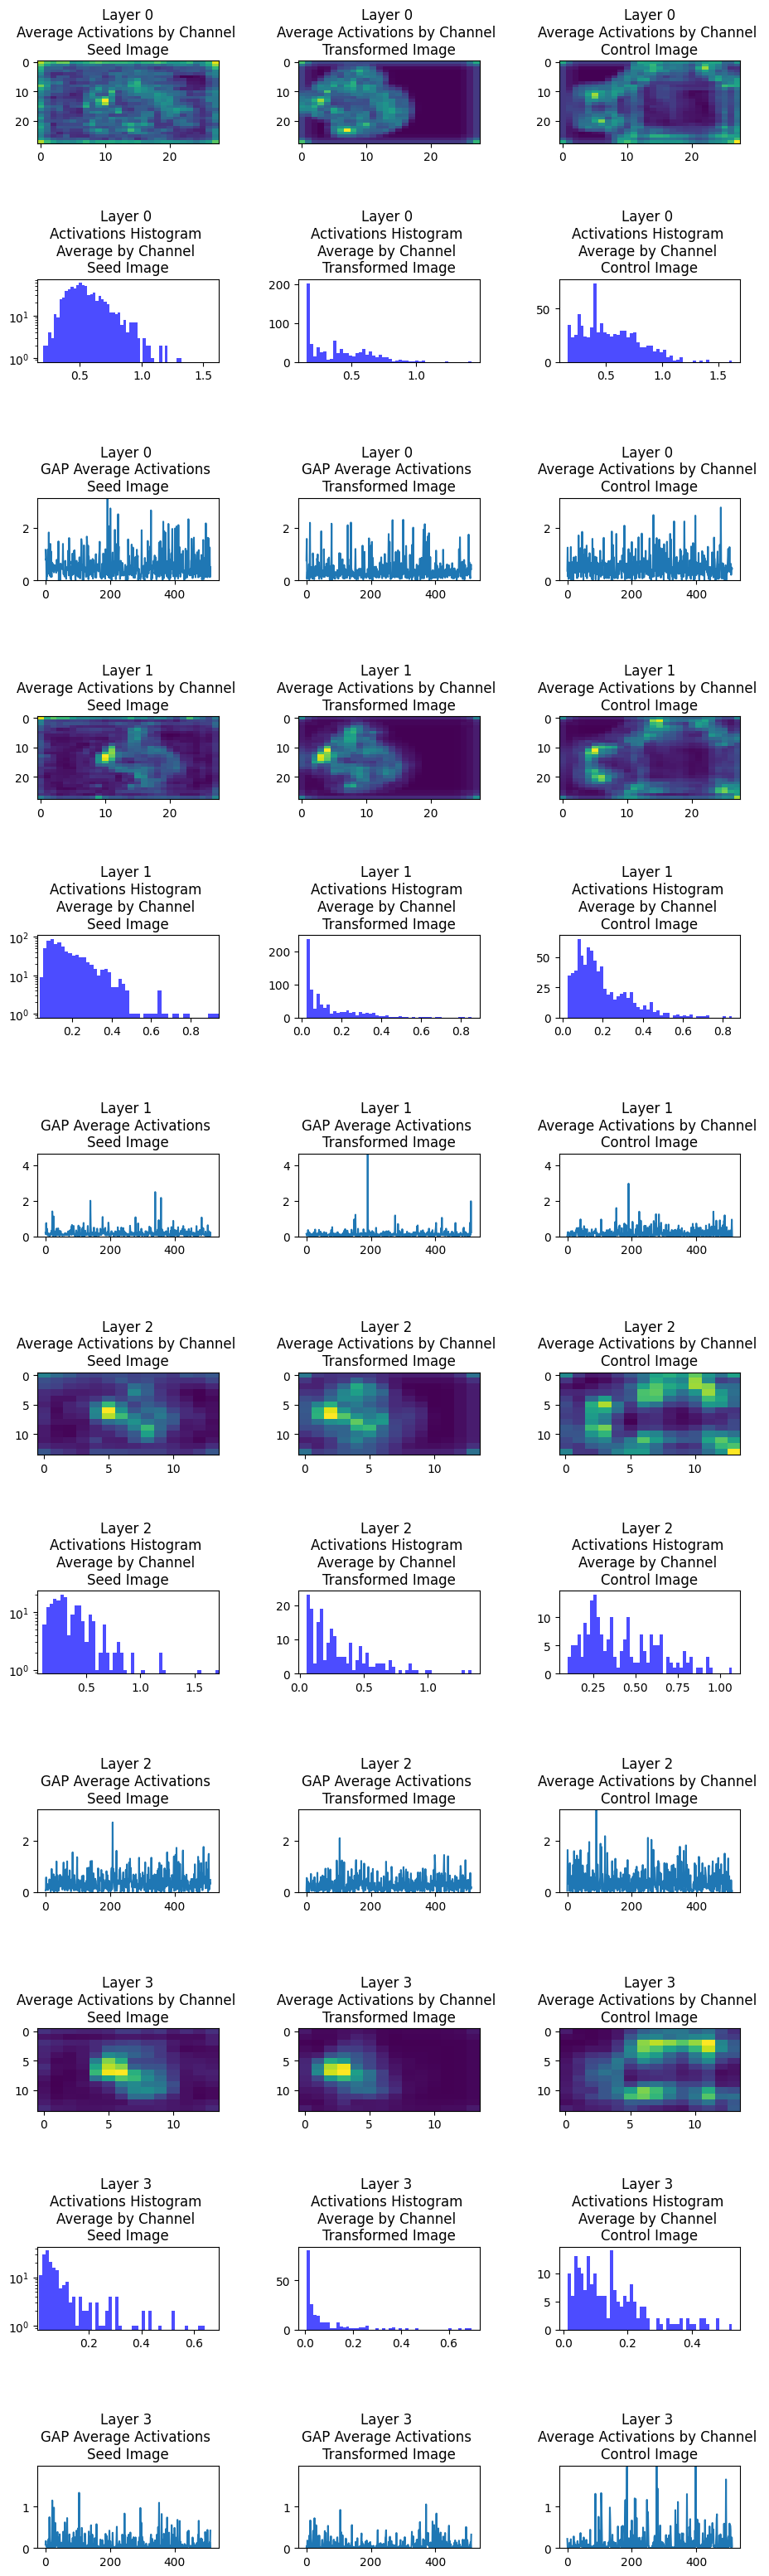

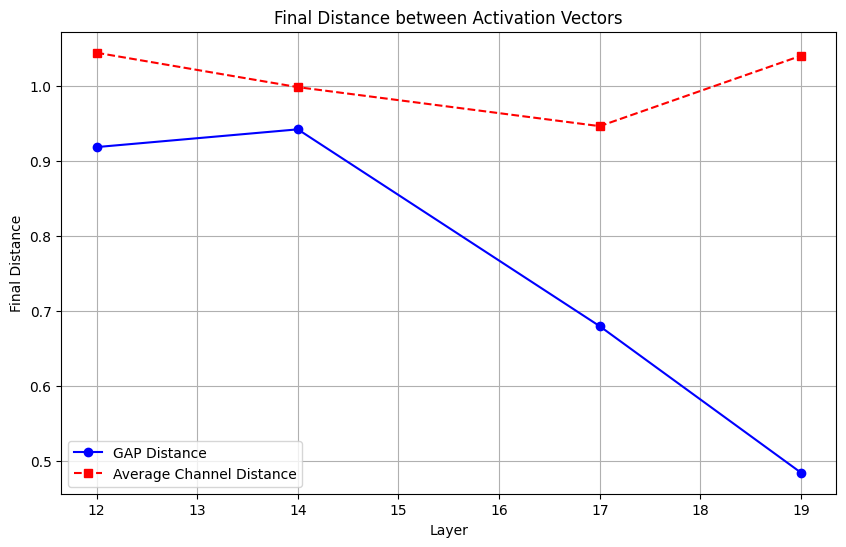

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_rotated_right.png


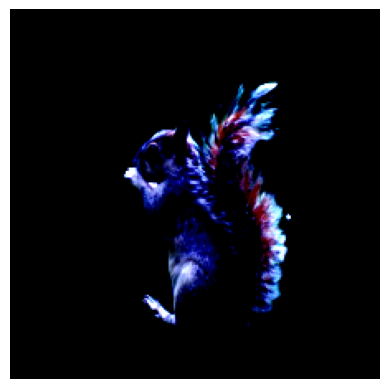


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 12 is: 14.294

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 12 is: 15.629

The final distance between the vectors using average GAP activations for layer 12 is: 0.915


The Euclidean distance between the vectors of an image and its transformation using the average channel activation of layer 12 is: 7.303

The Euclidean distance between classes of the vectors of two distinct images using the average channel activation of layer 12 is: 8.275

The final distance between the vectors using the average channel activation for layer 12 is: 0.883


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 14 is: 7.405

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 14 is: 

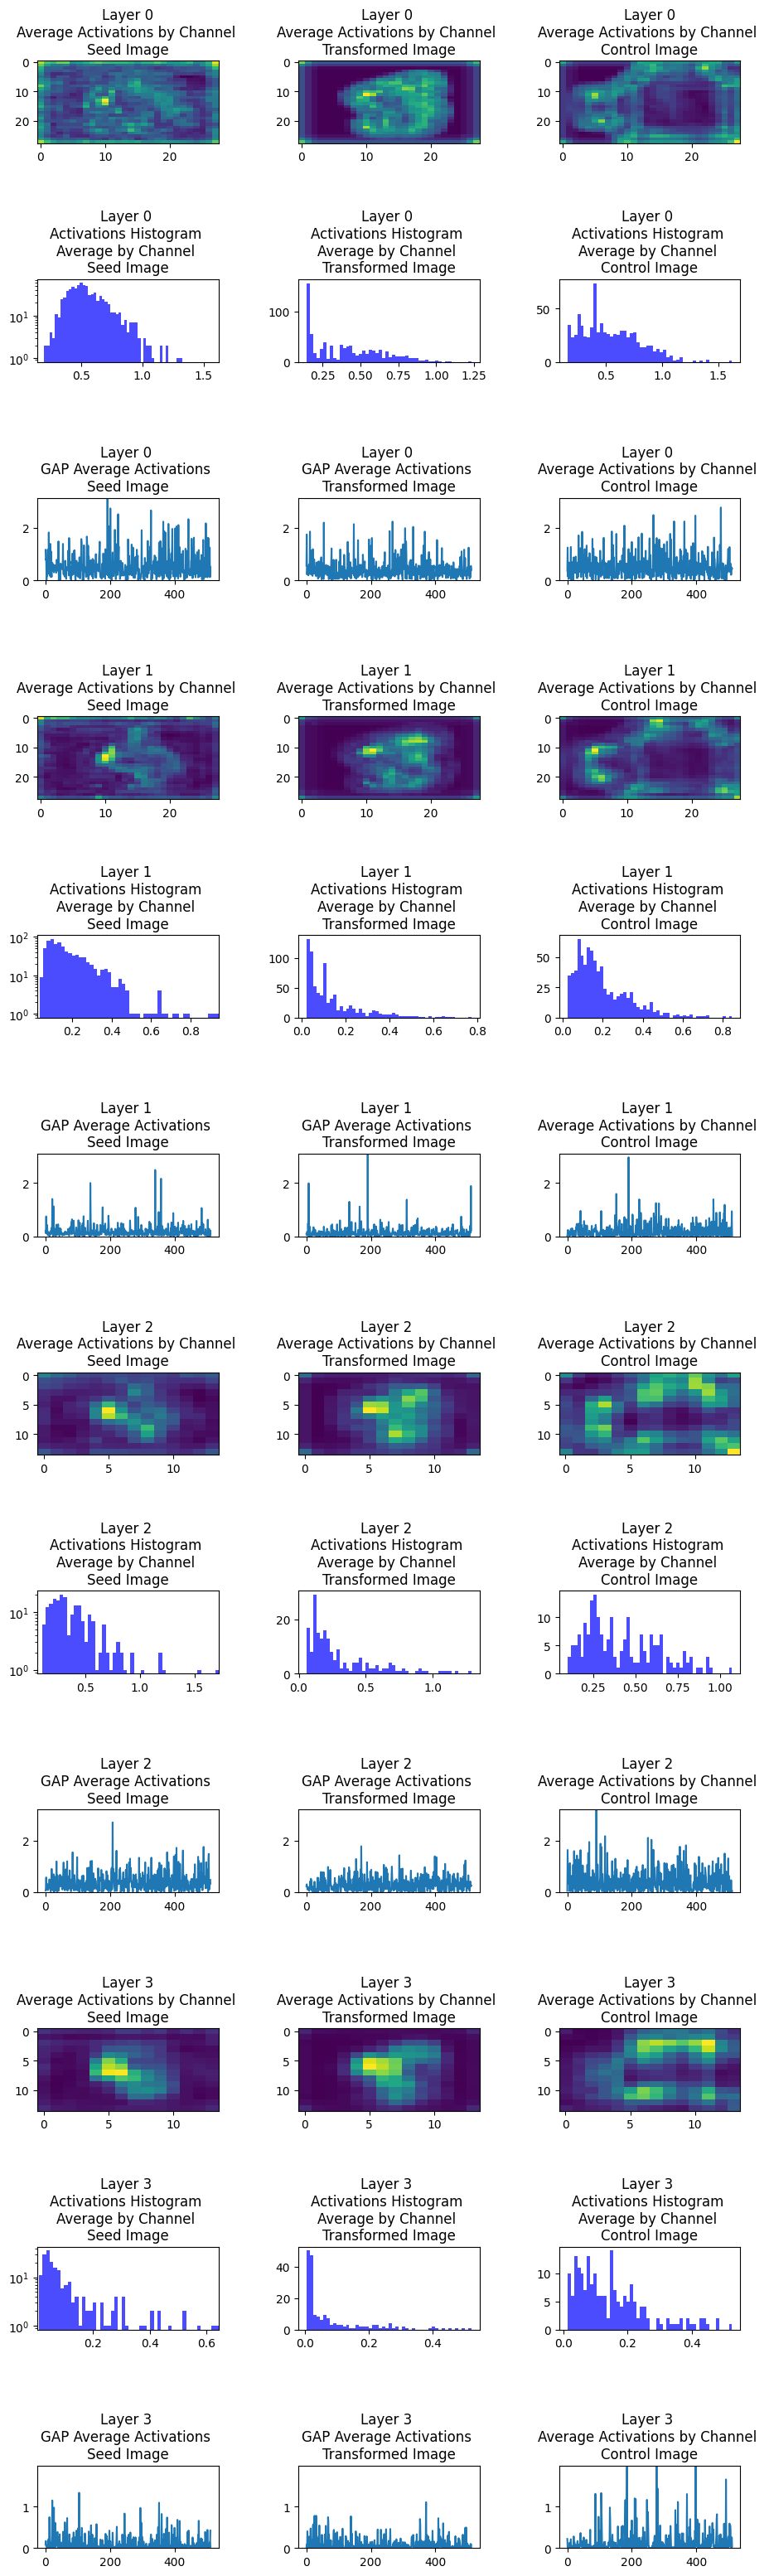

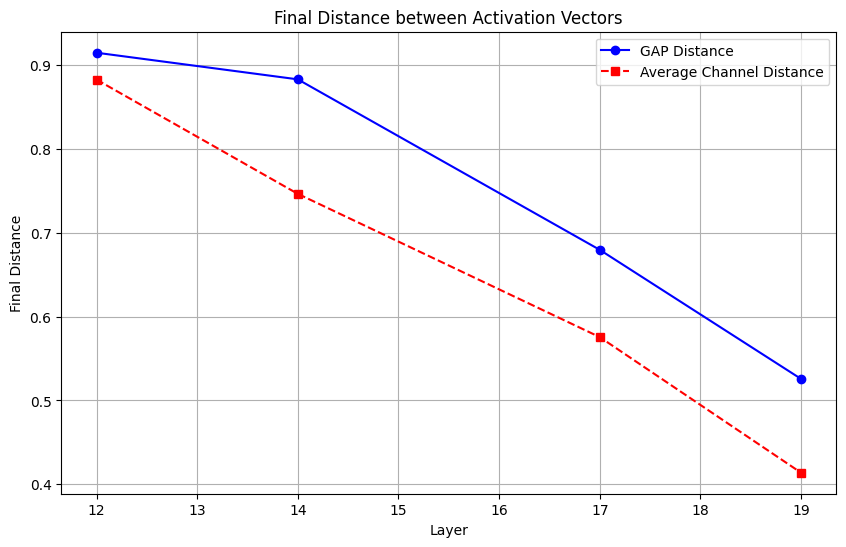

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_rotated_left.png


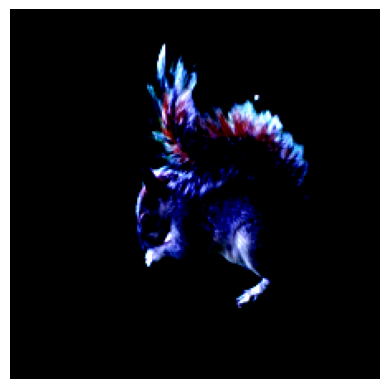


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 12 is: 14.160

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 12 is: 15.629

The final distance between the vectors using average GAP activations for layer 12 is: 0.906


The Euclidean distance between the vectors of an image and its transformation using the average channel activation of layer 12 is: 7.540

The Euclidean distance between classes of the vectors of two distinct images using the average channel activation of layer 12 is: 8.275

The final distance between the vectors using the average channel activation for layer 12 is: 0.911


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 14 is: 7.385

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 14 is: 

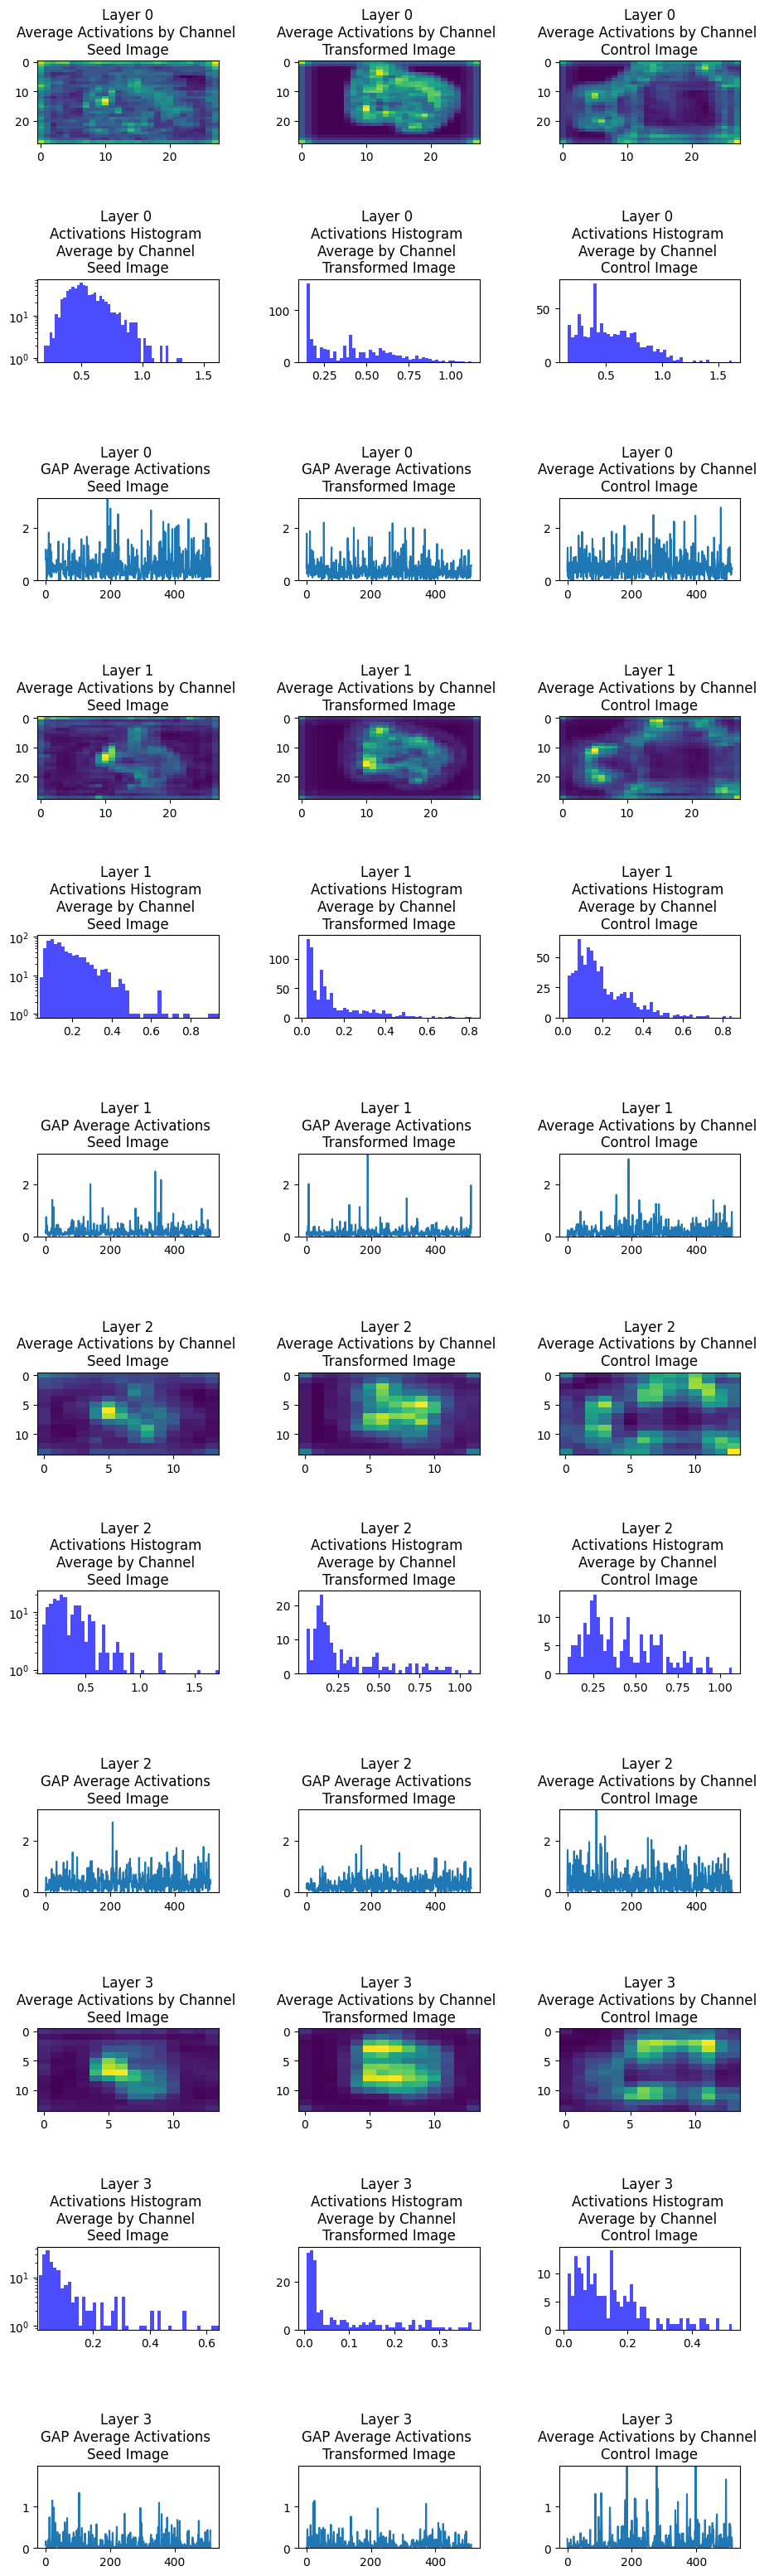

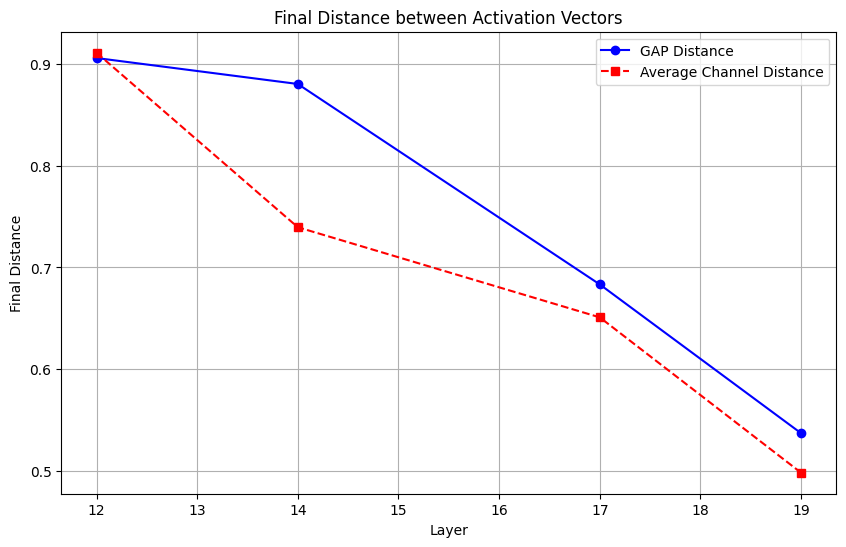

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_scaled1.png


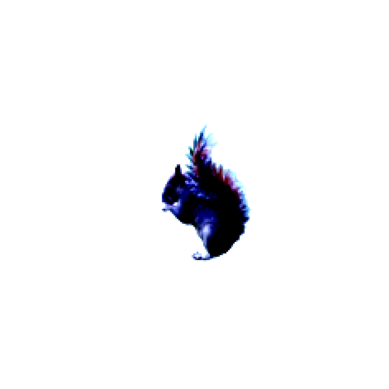


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 12 is: 16.230

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 12 is: 15.629

The final distance between the vectors using average GAP activations for layer 12 is: 1.038


The Euclidean distance between the vectors of an image and its transformation using the average channel activation of layer 12 is: 9.252

The Euclidean distance between classes of the vectors of two distinct images using the average channel activation of layer 12 is: 8.275

The final distance between the vectors using the average channel activation for layer 12 is: 1.118


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 14 is: 8.908

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 14 is: 

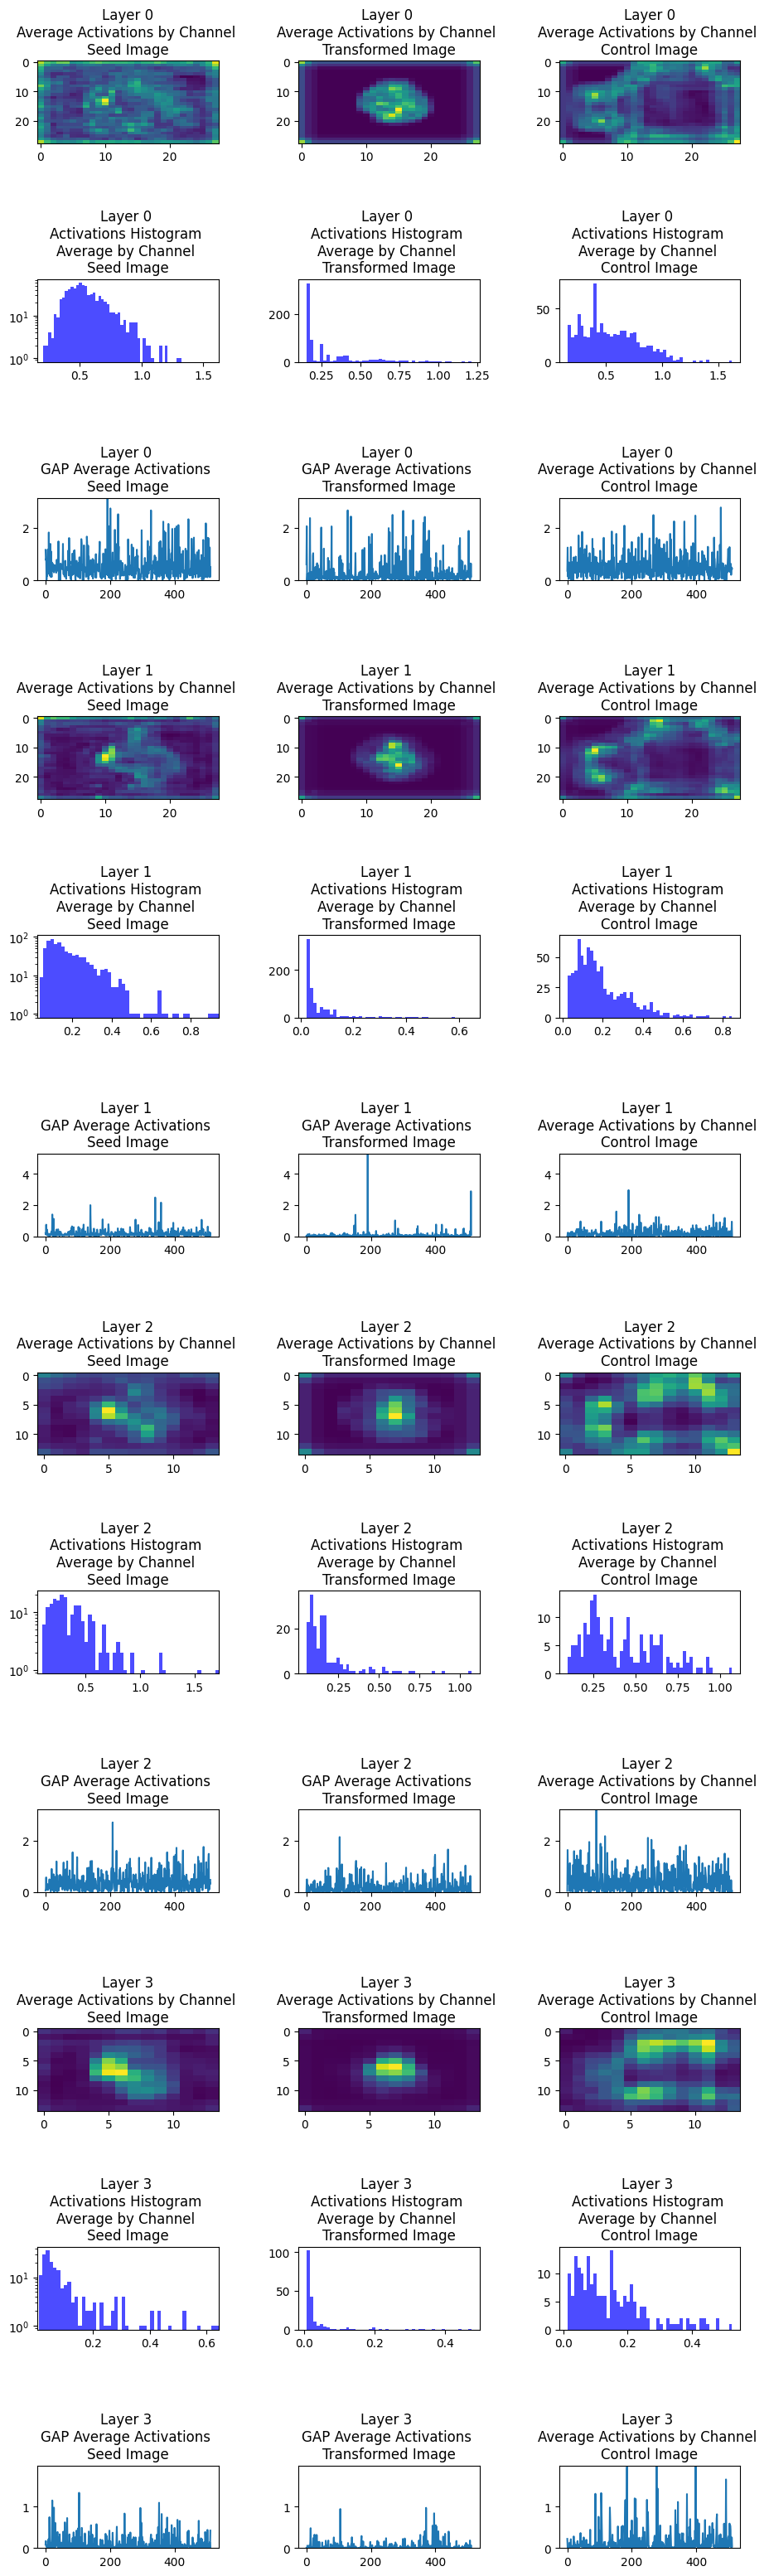

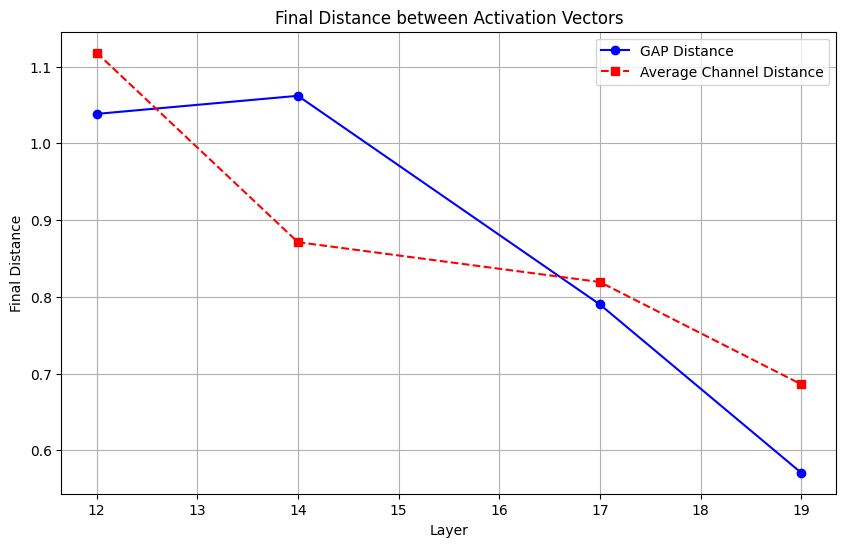

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_scaled2.png


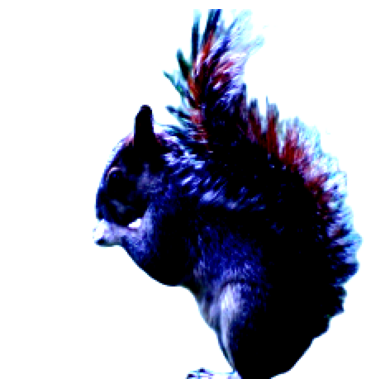


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 12 is: 12.553

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 12 is: 15.629

The final distance between the vectors using average GAP activations for layer 12 is: 0.803


The Euclidean distance between the vectors of an image and its transformation using the average channel activation of layer 12 is: 6.925

The Euclidean distance between classes of the vectors of two distinct images using the average channel activation of layer 12 is: 8.275

The final distance between the vectors using the average channel activation for layer 12 is: 0.837


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 14 is: 7.000

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 14 is: 

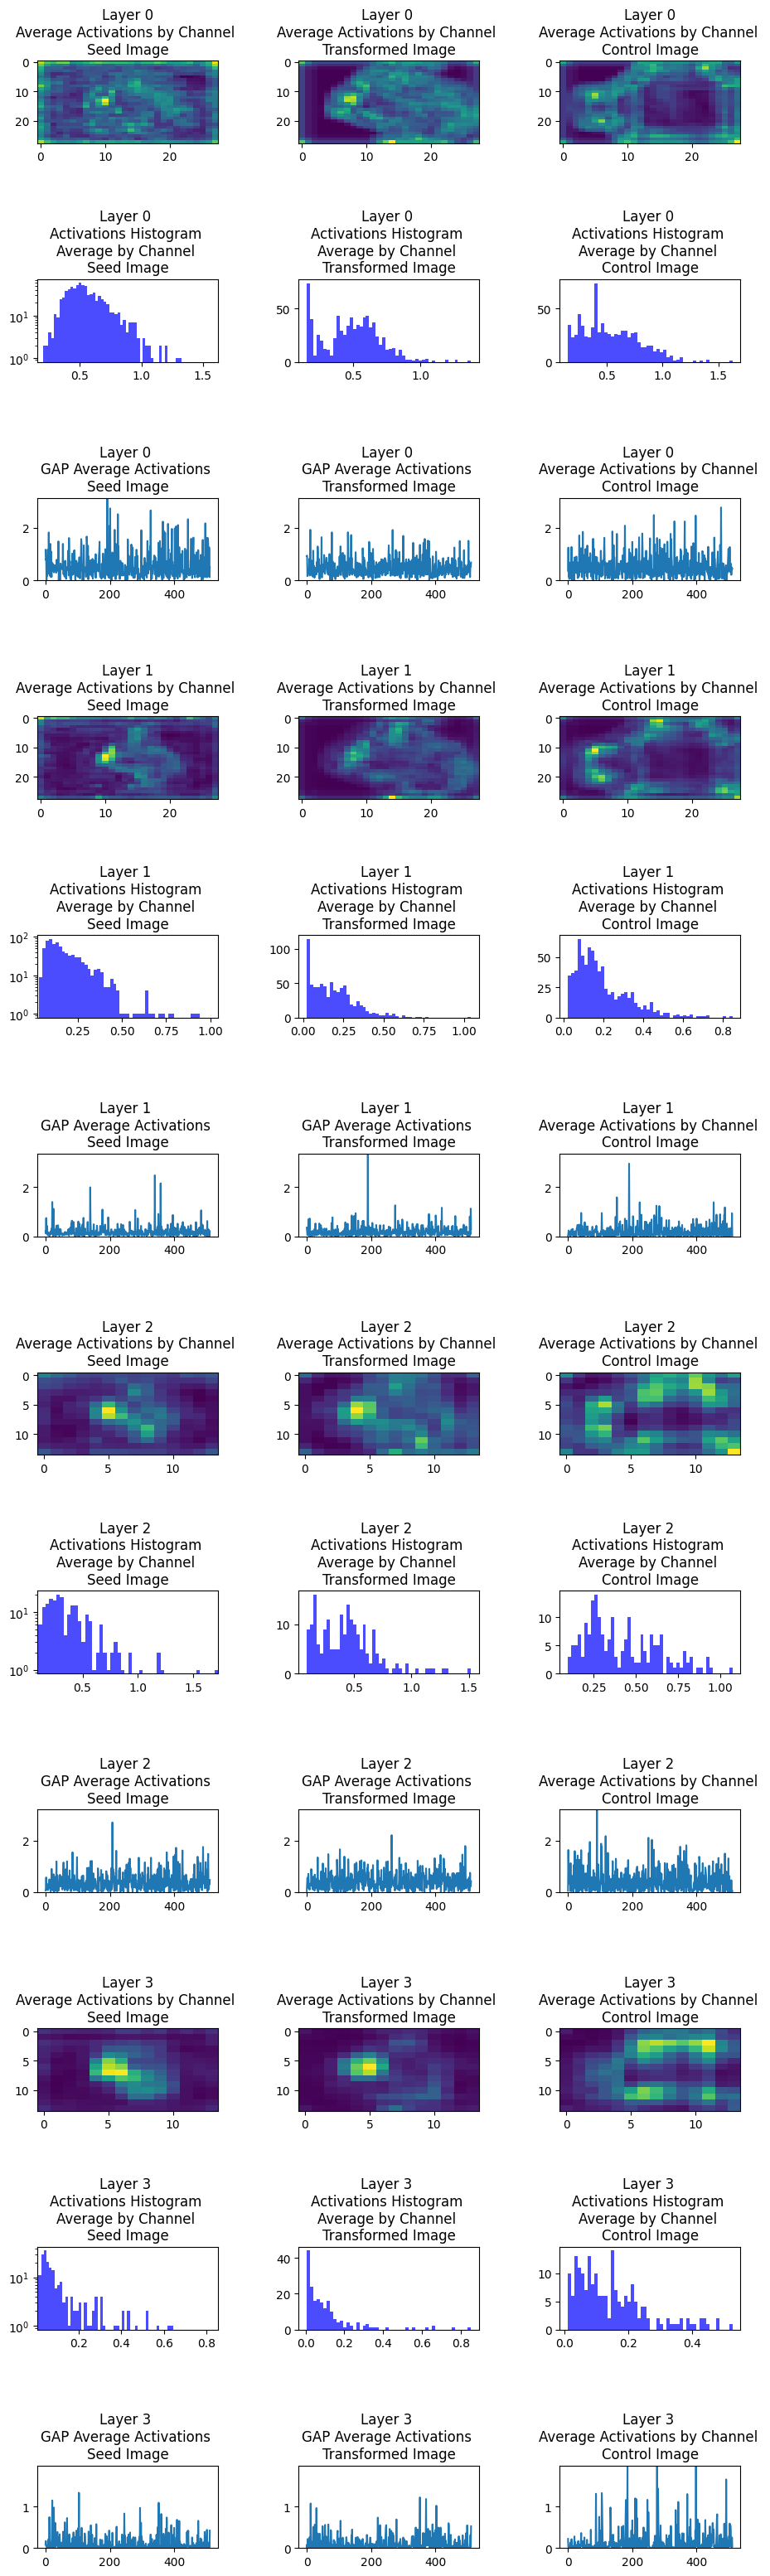

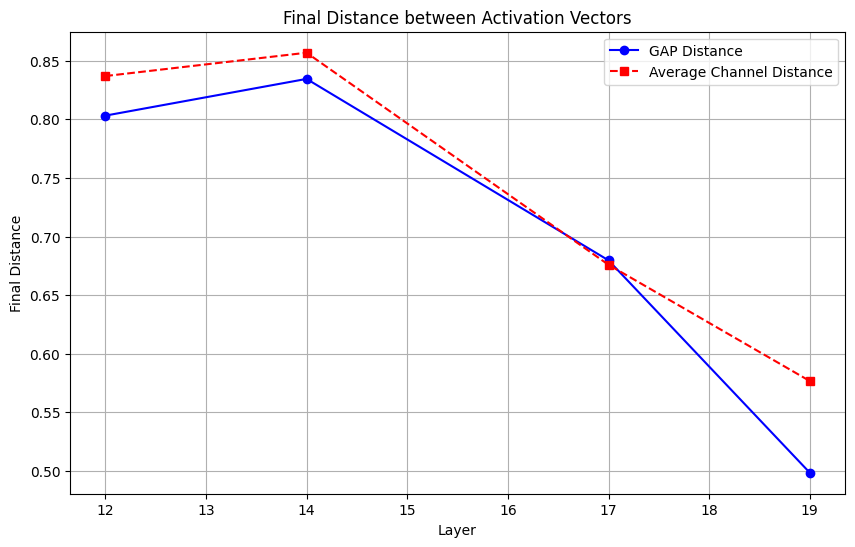

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_with_context.png


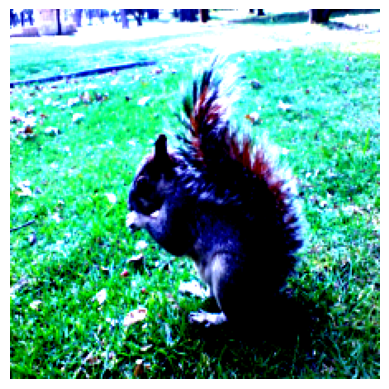


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 12 is: 0.000

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 12 is: 15.629

The final distance between the vectors using average GAP activations for layer 12 is: 0.000


The Euclidean distance between the vectors of an image and its transformation using the average channel activation of layer 12 is: 0.000

The Euclidean distance between classes of the vectors of two distinct images using the average channel activation of layer 12 is: 8.275

The final distance between the vectors using the average channel activation for layer 12 is: 0.000


The Euclidean distance between the vectors of an image and its transformation using the average GAP activation of layer 14 is: 0.000

The Euclidean distance between classes of the vectors of two distinct images using the average GAP activation of layer 14 is: 8

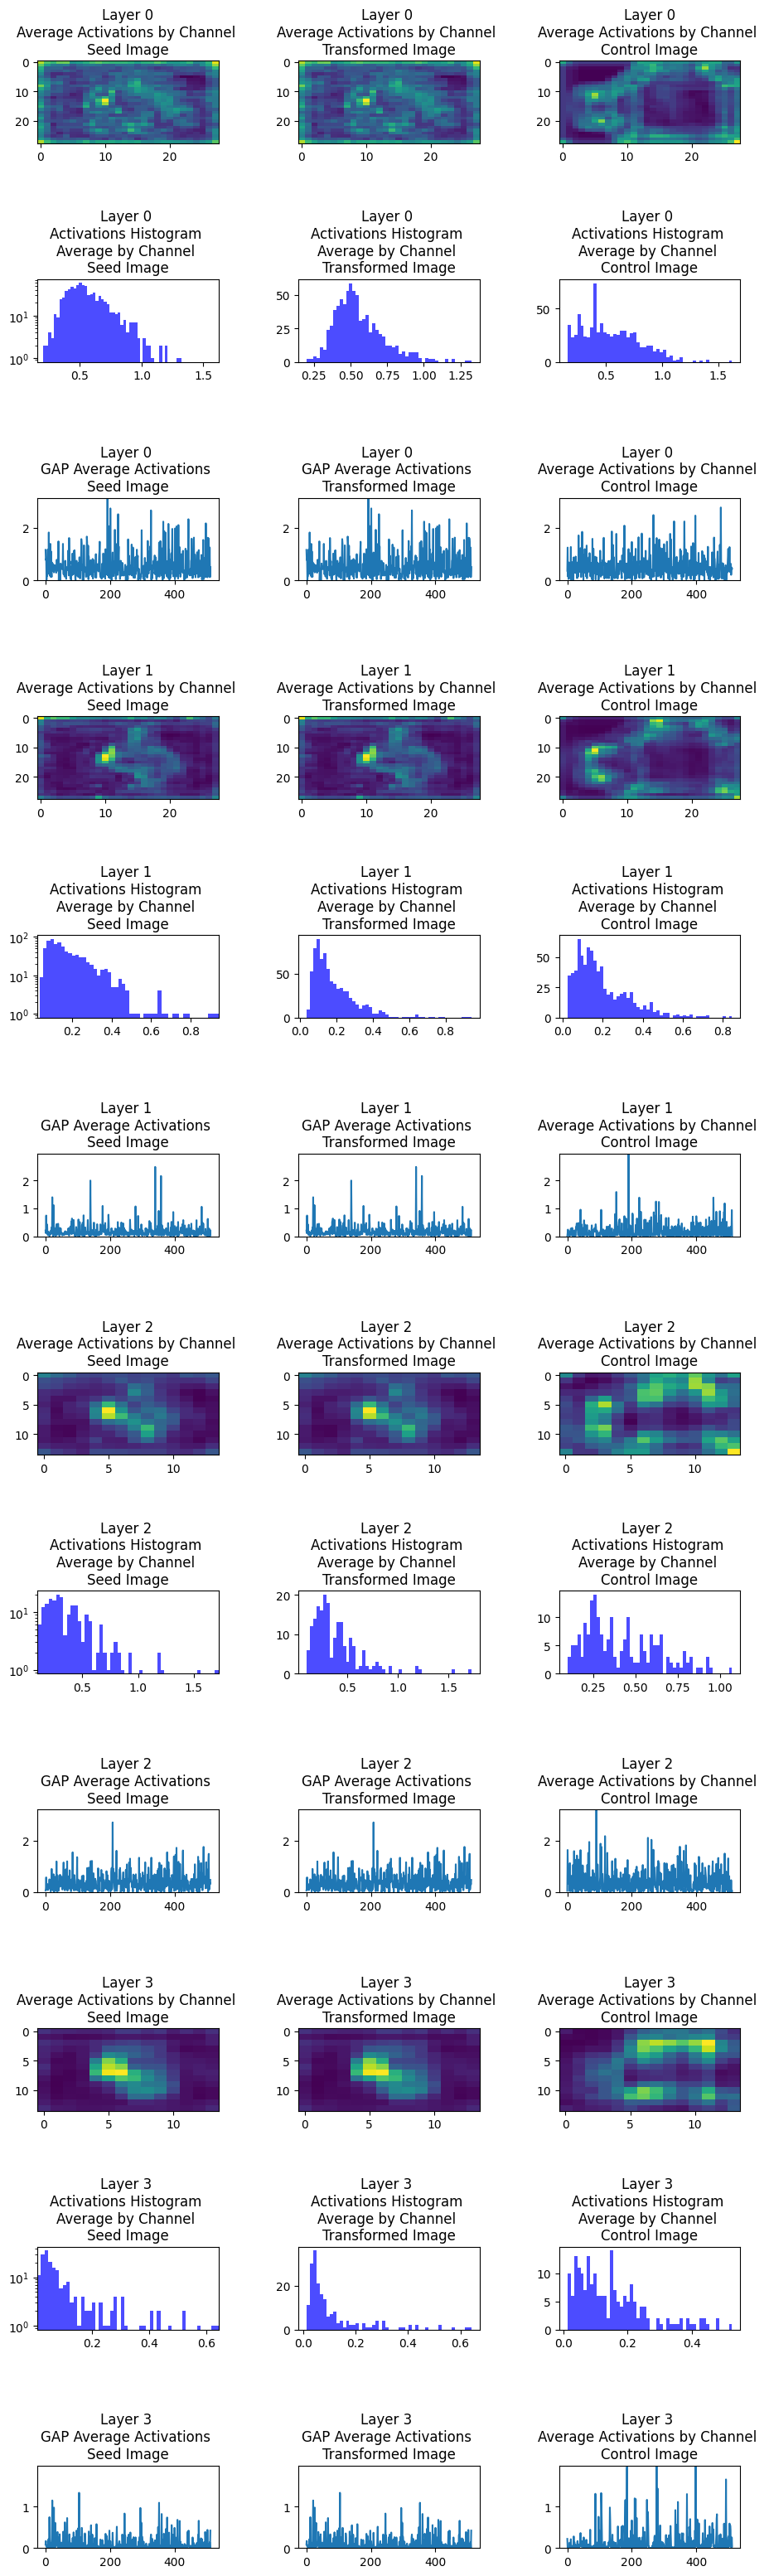

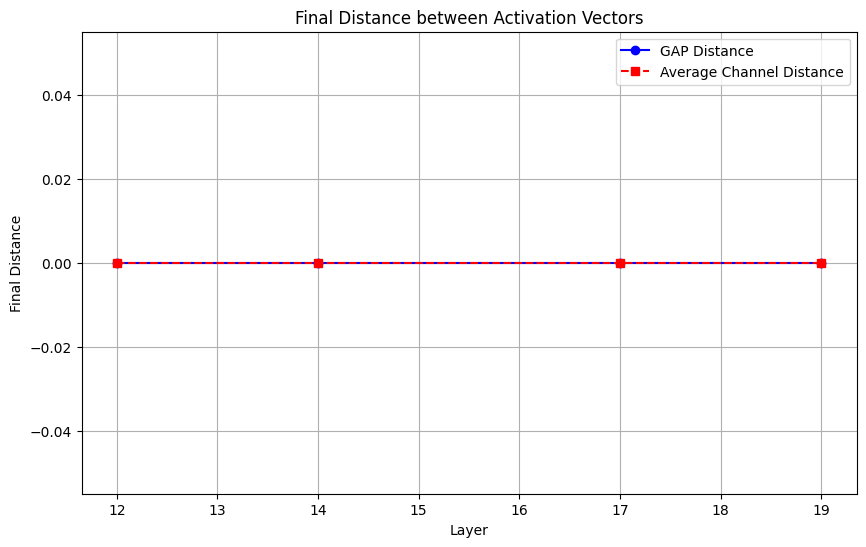

In [35]:
# Seed image activations
seed_activations = get_activations(model.features, seed_tensor, selected_leyers)
seed_avg_channel_act = average_channel_activations(seed_activations)
seed_avg_gap_act = gap_activations(seed_activations)

# Control image activations
control_activations = get_activations(model.features, control_tensor, selected_leyers)
control_avg_channel_act = average_channel_activations(control_activations)
control_avg_gap_act = gap_activations(control_activations)


# Transformed images activations
for idx, image_tensor in enumerate(transform_images_tensor):
    print(f"Processing image: {transform_image_list[idx]}")
    plt.imshow(image_tensor.squeeze(0).permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

    # Get activations for the current image tensor
    transform_activations = get_activations(model.features, image_tensor, selected_leyers)
    transform_avg_channel_act = average_channel_activations(transform_activations)
    transform_avg_gap_act = gap_activations(transform_activations)

    # Plot feature maps and average activations
    gap_distances_per_layer, avg_channel_distances_per_layer = plot_feature_maps_and_avg_activations(
        seed_avg_channel_act, transform_avg_channel_act, control_avg_channel_act,
        seed_avg_gap_act, transform_avg_gap_act, control_avg_gap_act,
        selected_leyers
    )

    #store results
    gap_distances_all_list.append(gap_distances_per_layer)
    avg_channels_distances_all_list.append(avg_channel_distances_per_layer)

## Sparseness analysis

In this section, we conduct a sparseness analysis of the model layer by layer, transformation by transformation. This analysis aims to examine the distribution of activations across different layers, providing insights into how sparsely activated the neurons are in response to different inputs.
The findings from this analysis will be further evaluated in the context of the overall project.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: seed_object.png


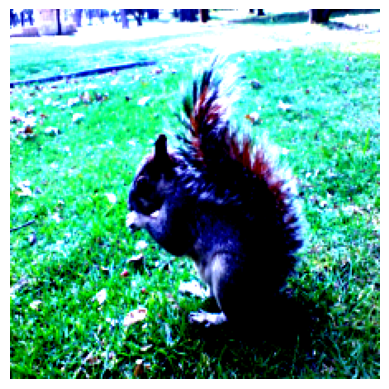

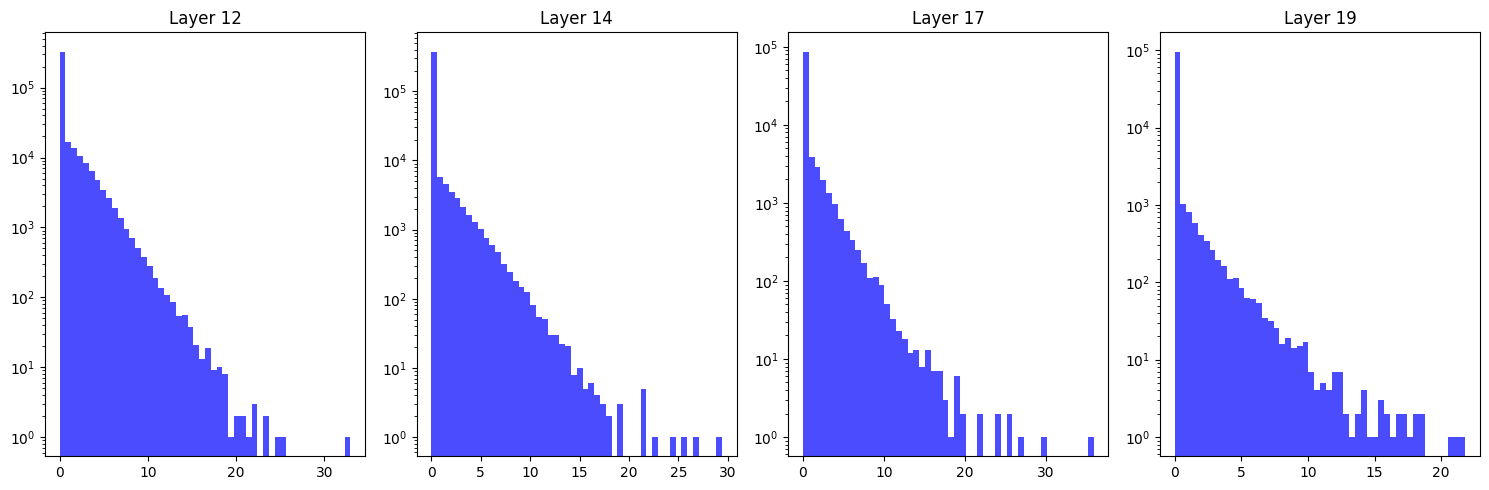

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_shifted_right.png


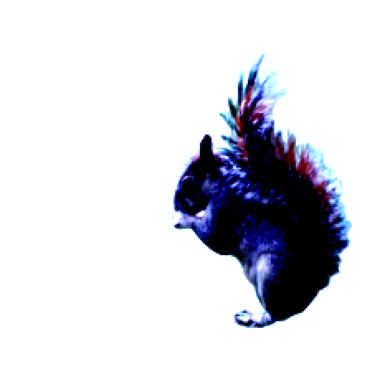

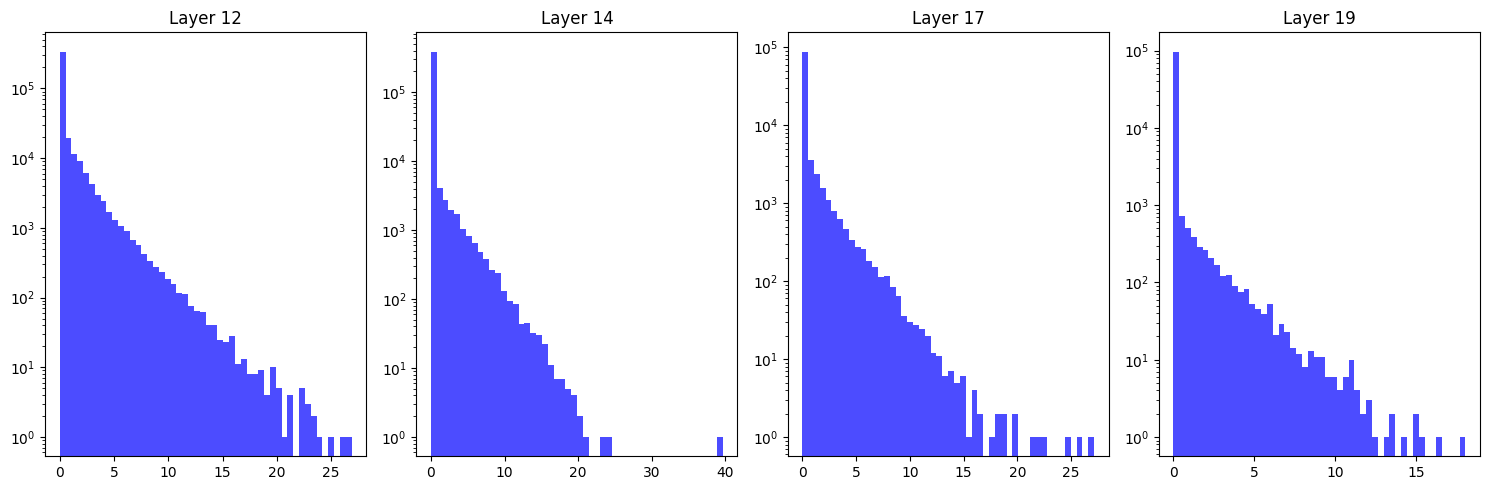

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_shifted_left.png


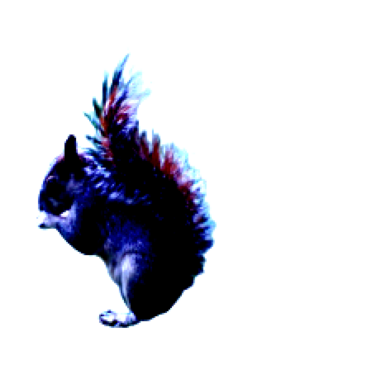

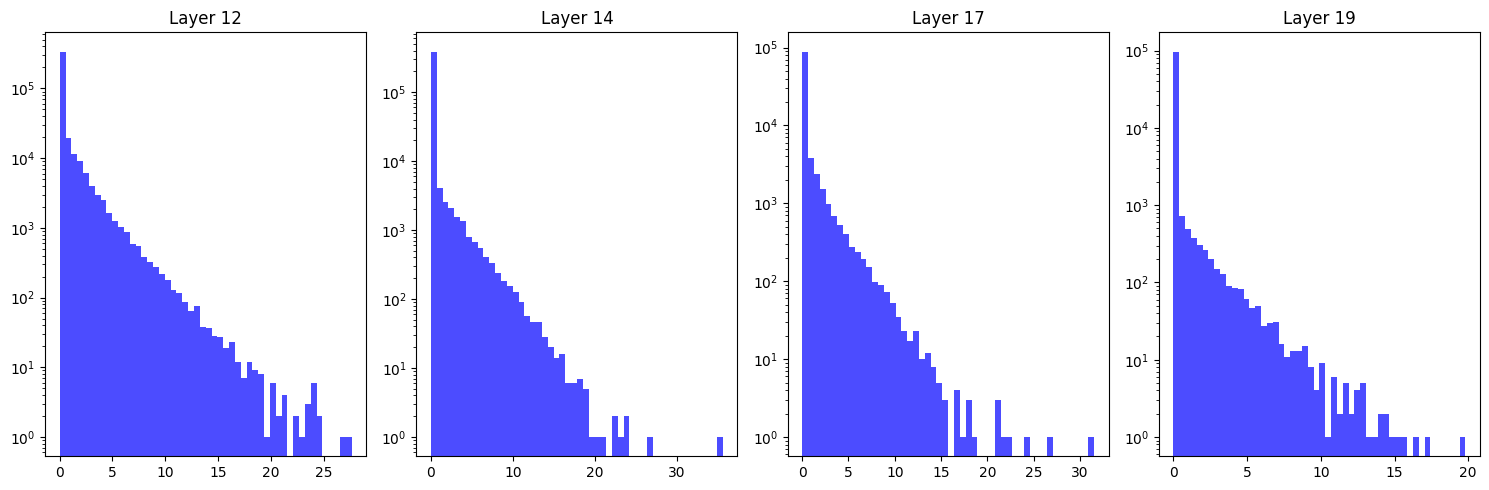

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_rotated_right.png


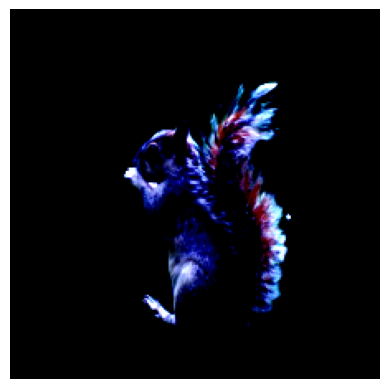

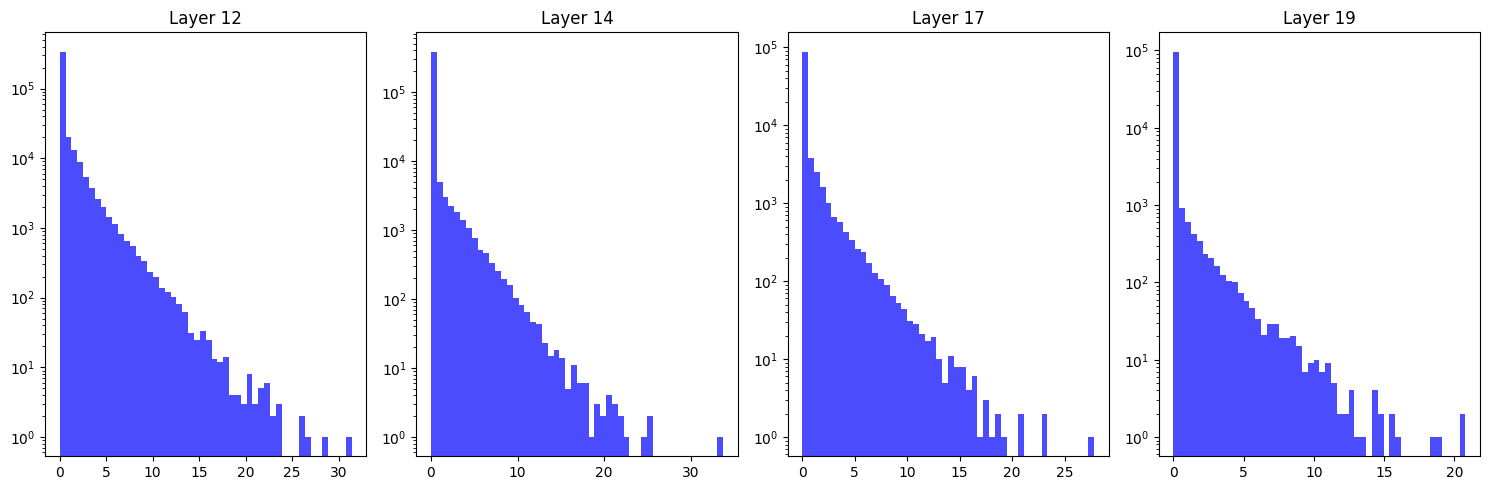

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_rotated_left.png


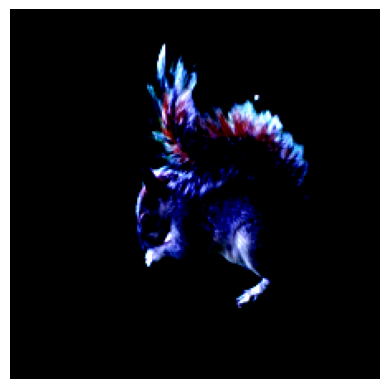

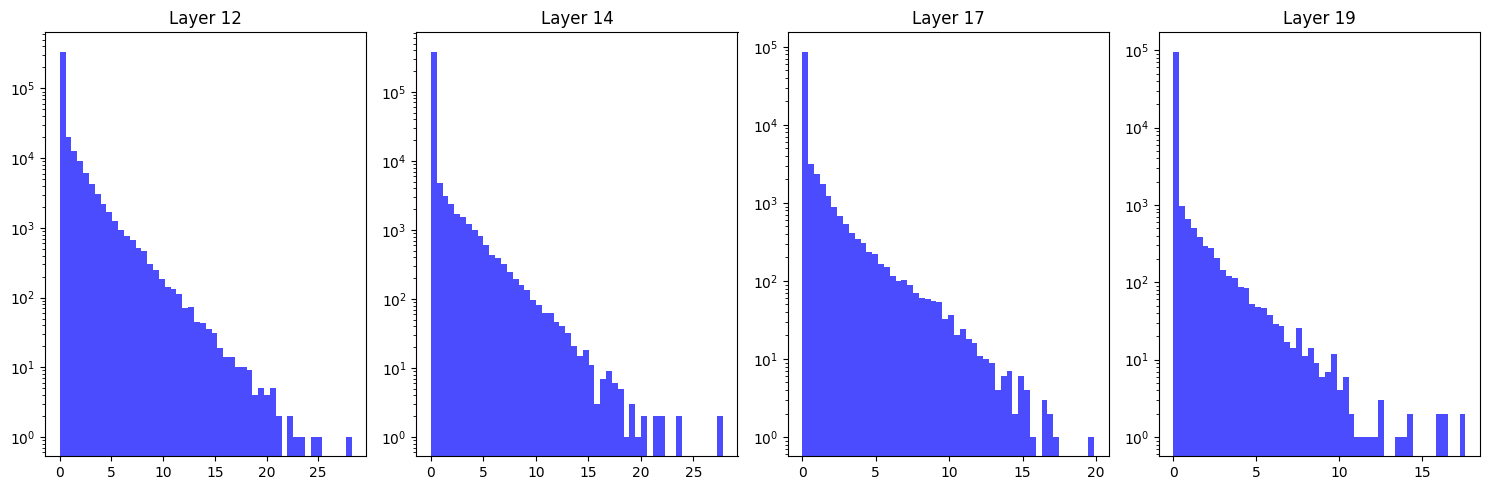

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_scaled1.png


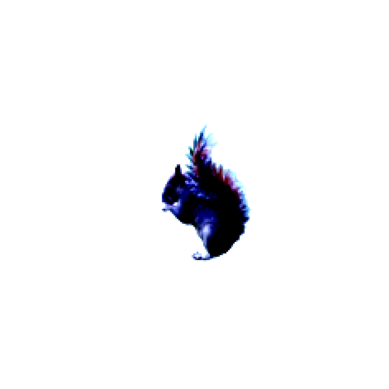

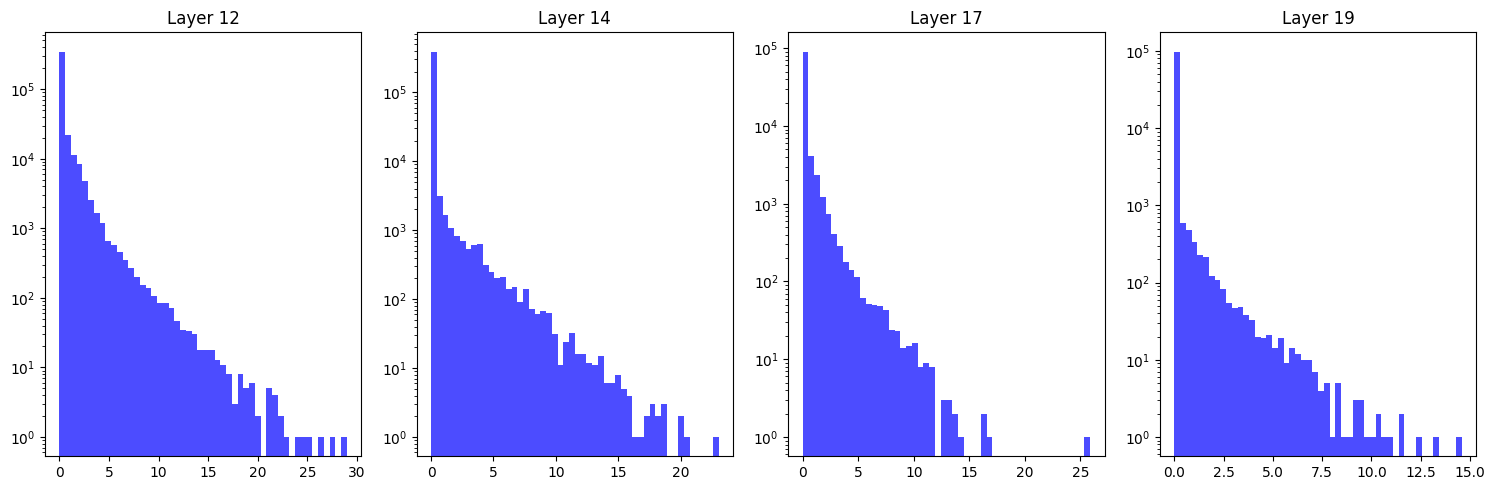

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_scaled2.png


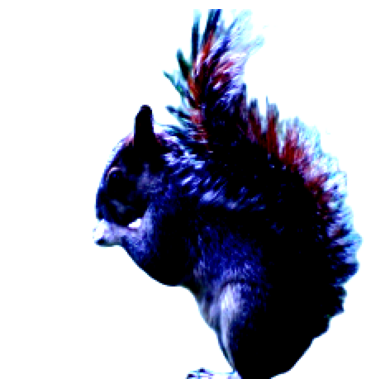

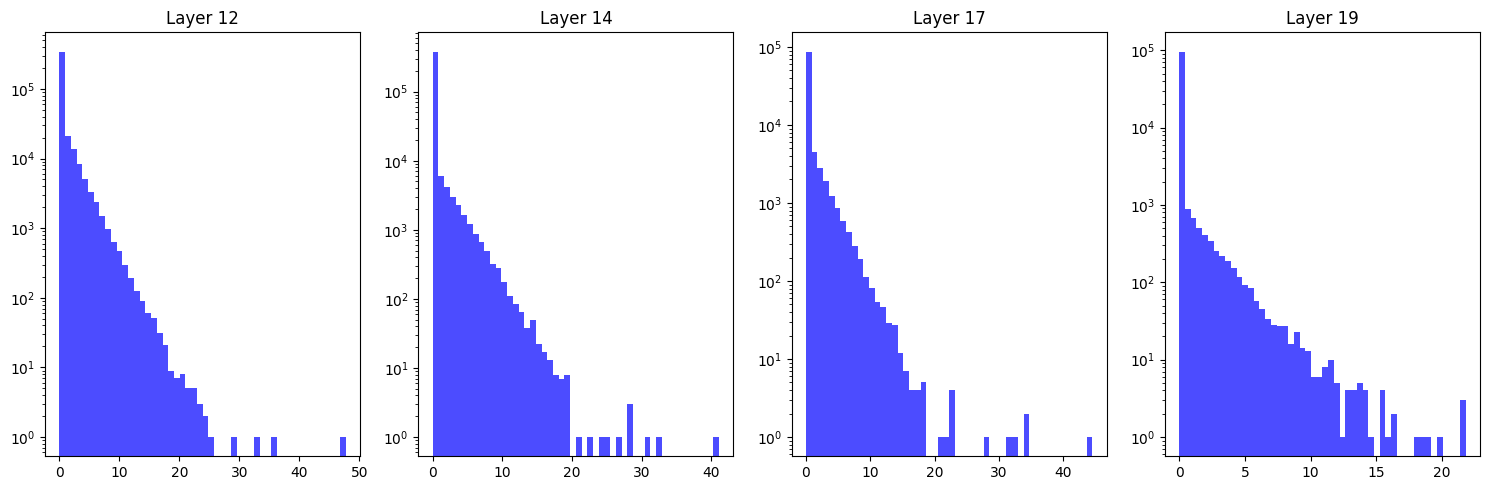

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processing image: object_with_context.png


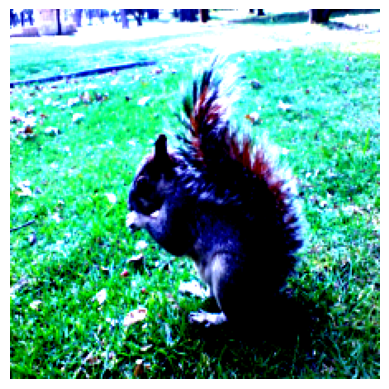

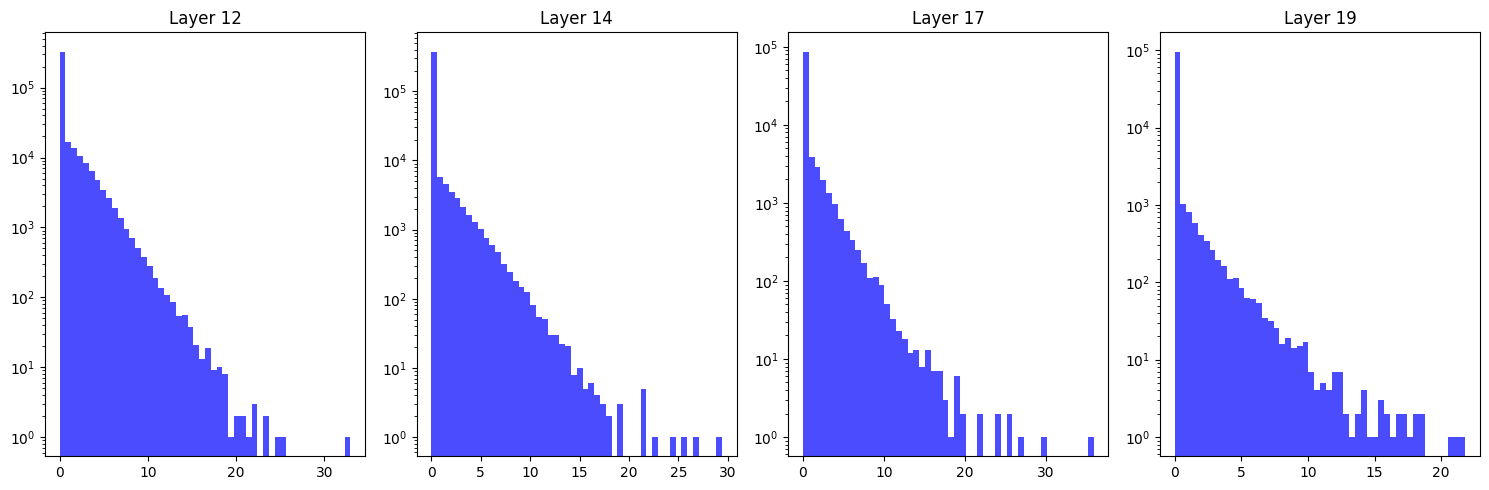

In [36]:
# Initialize a dictionary to store activations
all_activations = {}

all_activations[f'seed_object'] = seed_activations

print(f"Processing image: seed_object.png")
plt.imshow(seed_tensor.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

# Plot sparseness for the seed image activations
plot_sparseness(transform_activations, selected_leyers)


# Process transformed images activations
for idx, image_tensor in enumerate(transform_images_tensor):

    print(f"Processing image: {transform_image_list[idx]}")
    plt.imshow(image_tensor.squeeze(0).permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

    # Get activations for the current image tensor
    transform_activations = get_activations(model.features, image_tensor, selected_leyers)
    all_activations[f'transform_activations_{idx}'] = transform_activations

    # Plot sparseness for the transformed image activations
    plot_sparseness(transform_activations, selected_leyers)

# Project Evaluation

In this section, we evaluate the results of the experiment by analyzing the average distances calculated from the invariance and sparseness analyses.

## Invariance

 We compute the mean GAP distance and average channel distance across all transformations for each layer. This provides insights into how transformations affect the activations and whether the model maintains invariance in its feature extraction process.

The evaluation is visualized through two plots: one representing the average GAP distance and the other illustrating the average channel distance across the selected layers. These visualizations help us understand the model's behavior and robustness in handling various transformations.

In [37]:
# Calculate average distances
gap_distance_total = np.mean(gap_distances_all_list, axis=0)
avg_channels_distance_total = np.mean(avg_channels_distances_all_list, axis=0)

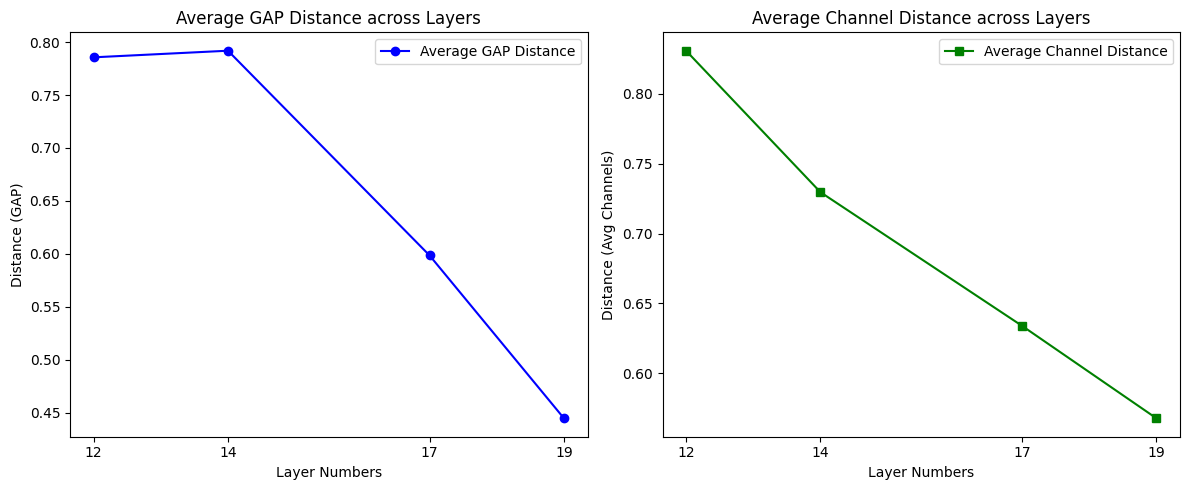

In [38]:
plt.figure(figsize=(12, 5))

# Plot GAP distance averages
plt.subplot(1, 2, 1)
plt.plot(selected_leyers, gap_distance_total, label="Average GAP Distance", color="blue", marker='o')
plt.xticks(selected_leyers)  # Set x-ticks to actual layer numbers
plt.xlabel("Layer Numbers")
plt.ylabel("Distance (GAP)")
plt.title("Average GAP Distance across Layers")
plt.legend()

# Plot average channel distances
plt.subplot(1, 2, 2)
plt.plot(selected_leyers, avg_channels_distance_total, label="Average Channel Distance", color="green", marker='s')
plt.xticks(selected_leyers)  # Set x-ticks to actual layer numbers
plt.xlabel("Layer Numbers")
plt.ylabel("Distance (Avg Channels)")
plt.title("Average Channel Distance across Layers")
plt.legend()

plt.tight_layout()
plt.show()

## Sparseness

In this section we compute the sparseness for each transformation and accumulate the results for all selected layers. Finally, we calculate the average sparseness per layer and visualize these results through a plot, which helps us understand how the model's feature representations vary across different layers.

Layer: 12, Average Sparseness: 0.895365
Layer: 14, Average Sparseness: 0.968962
Layer: 17, Average Sparseness: 0.921849
Layer: 19, Average Sparseness: 0.979024


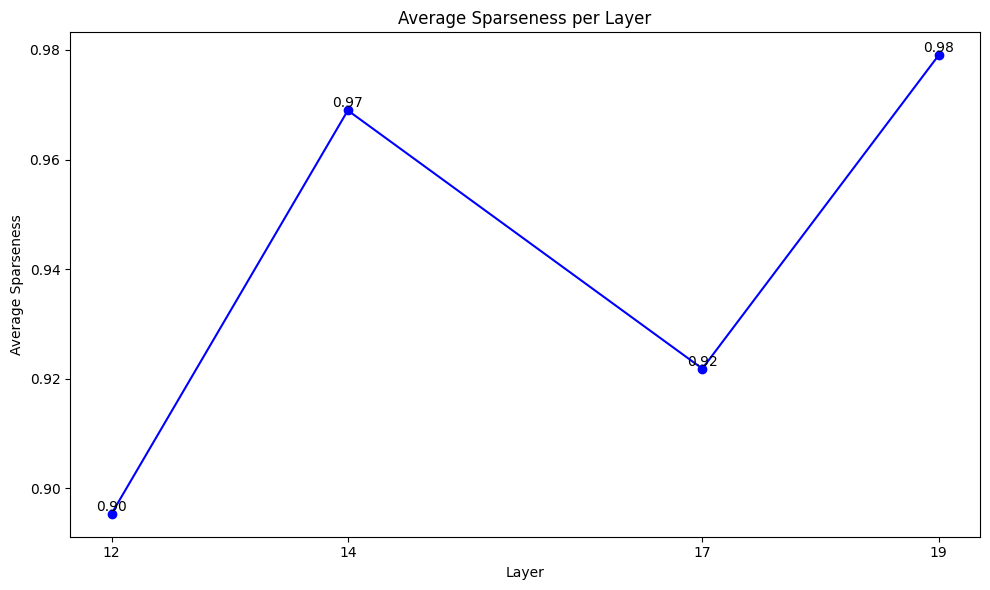

In [39]:
# Calculate sparseness for all transformations
sparseness_results = []
for key, activations in all_activations.items():
    for i, activacion in enumerate(activations):
        sparseness_results.append(compute_sparseness_for_activations(selected_leyers[i], activacion))


# Initialize a defaultdict to store sums and counts for each layer
layer_sparseness_sum_count = defaultdict(lambda: [0, 0])  # [sum, count]

# Accumulate sums and counts for each layer
for layer, sparseness in sparseness_results:
    layer_sparseness_sum_count[layer][0] += np.sum(sparseness)  # Add to sum
    layer_sparseness_sum_count[layer][1] += sparseness.size  # Increment count by the number of values

# Compute average sparseness for each layer
average_sparseness_per_layer = {
    layer: total_sum / count if count > 0 else 0
    for layer, (total_sum, count) in layer_sparseness_sum_count.items()
}

# Print the average sparseness for each layer
for layer, avg in average_sparseness_per_layer.items():
    print(f"Layer: {layer}, Average Sparseness: {avg:.6f}")

# Extract keys and values for plotting
layers = list(average_sparseness_per_layer.keys())
average_sparseness = list(average_sparseness_per_layer.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(layers, average_sparseness, marker='o', linestyle='-', color='b')

# Add labels and title
plt.title('Average Sparseness per Layer')
plt.xlabel('Layer')
plt.ylabel('Average Sparseness')
plt.xticks(layers)  # Set x-ticks to be the layer keys

for i, value in enumerate(average_sparseness):
    plt.text(layers[i], value, f'{value:.2f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

# References
<a id="1">[1]</a>
Rust, N. C., & DiCarlo, J. J. (2010). Selectivity and Tolerance (“Invariance”) Both Increase as Visual Information Propagates from Cortical Area V4 to IT. Journal of Neuroscience, 30(39), 12978–12995. https://doi.org/10.1523/jneurosci.0179-10.2010

<a id="2">[2]</a>
Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.

<a id="3">[3]</a>
Vinje, W. E., & Gallant, J. L. (2000). Sparse Coding and Decorrelation in Primary Visual Cortex During Natural Vision. Science, 287(5456), 1273-1276.

<a id="4">[4]</a>
Rust, N. C., and J. J. DiCarlo. “Balanced Increases in Selectivity and Tolerance Produce Constant Sparseness Along the Ventral Visual Stream.” Journal of Neuroscience 32.30 (2012): 10170–10182.